In [4]:
# noinspection JupyterPackage
import os
import pandas as pd
import numpy as np

In [5]:
data_dir = '/Users/xiaoqianxiao/UKB/data'
participantsInfo_file = 'participants_structural.csv'
participantsInfo_file_path = os.path.join(data_dir,participantsInfo_file)
participantsInfo_df = pd.read_csv(participantsInfo_file_path)

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_73929/3336274664.py:4: DtypeWarning: Columns (266,268,270,272,274,276) have mixed types. Specify dtype option on import or set low_memory=False.
  participantsInfo_df = pd.read_csv(participantsInfo_file_path)


In [6]:
# Tian 1:10, 17:26
#'HIP-rh','AMY-rh','pTHA-rh','aTHA-rh','NAc-rh','GP-rh','PUT-rh','CAU-rh',
#'HIP-lh','AMY-lh','pTHA-lh','aTHA-lh','NAc-lh','GP-lh','PUT-lh','CAU-lh'
subcortical_index = [i + 360 for i in range(0, 5)] + [i + 360 for i in range(8, 13)]
subcortical_index_ori = list(range(0,5)) + list(range(8,13))


# Schaefer: 
# lh-mPFC: 199:205
# rh-mPFC: 464:470
# lh-Ins: 67, 108:111, 126:128
# rh-Ins: 319, 361:364, 383:386
## ACC: 390
# Glasser
cortical_roi = ['lh_dlPFC', 'rh_dlPFC', 'lh_mPFC', 'rh_mPFC', 'lh_PCC', 'rh_PCC', 'lh_Ins', 'rh_Ins']
lh_dlPFC_index = [205, 246, 247, 249, 250, 252, 262, 263, 264, 265, 266, 276, 277]
rh_dlPFC_index = [25, 66, 67, 69, 70, 72, 82, 83, 84, 85, 86, 96, 97]
lh_mPFC_index = [236, 237, 238, 239, 240, 241, 242, 243, 244, 248, 267, 343, 344, 345, 358, 359]
rh_mPFC_index = [56, 57, 58, 59, 60, 61, 62, 63, 64, 68, 87, 163, 164, 165, 178, 179]
lh_PCC_index = [193, 194, 206, 209, 210, 211, 212, 213, 214, 300, 321, 340, 341]
rh_PCC_index = [13, 14, 26, 29, 30, 31, 32, 33, 34, 120, 141, 160, 161]
lh_Ins_index = [285, 287, 288, 289, 290, 291, 293, 294, 346, 347, 348, 357]
rh_Ins_index = [105, 107, 108, 109, 110, 111, 113, 114, 166, 167, 168, 177]
dic_cortical_roi = {
    'lh_dlPFC': lh_dlPFC_index,
    'rh_dlPFC': rh_dlPFC_index,
    'lh_mPFC': lh_mPFC_index,
    'rh_mPFC': rh_mPFC_index,
    'lh_PCC': lh_PCC_index,
    'rh_PCC': rh_PCC_index,
    'lh_Ins': lh_Ins_index,
    'rh_Ins': rh_Ins_index
}

In [7]:
1024/(13*60) * 2902 /60

63.496752136752136

In [78]:
parcellation_dir = '/Users/xiaoqianxiao/tool/parcellation'
sub_cortical_filename = 'Tian_Subcortex_S1_3T_label.csv'
sub_cortical_file_path = os.path.join(parcellation_dir, sub_cortical_filename)
df_sub_cortical_name = pd.read_csv(sub_cortical_file_path, header=None)
df_sub_cortical_roi_name_need = df_sub_cortical_name.iloc[subcortical_index_ori,0]
df_cortical_roi_name = pd.DataFrame(cortical_roi)
df_roi_name = pd.concat([df_cortical_roi_name, df_sub_cortical_roi_name_need],ignore_index=True)
df_roi_name.columns = ['roi_name']
from itertools import combinations
combinations_list = list(combinations(df_roi_name['roi_name'], 2))
df_roi_combinations = pd.DataFrame(combinations_list, columns=['ROI1', 'ROI2'])
print(df_roi_combinations)

         ROI1      ROI2
0    lh_dlPFC  rh_dlPFC
1    lh_dlPFC   lh_mPFC
2    lh_dlPFC   rh_mPFC
3    lh_dlPFC    lh_PCC
4    lh_dlPFC    rh_PCC
..        ...       ...
148    lh_AMY   lh_aTHA
149    lh_AMY    lh_Nac
150   lh_pTHA   lh_aTHA
151   lh_pTHA    lh_Nac
152   lh_aTHA    lh_Nac

[153 rows x 2 columns]


In [79]:
from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure


# === Step 1: Define Functions === #

def load_dataset(base_dir, data_set):
    """
    Load dataset-specific files.
    """
    fMRIinfo_file_path = os.path.join(base_dir, f"{data_set}_data_set.csv")
    participant_file_path = os.path.join(base_dir, "participants_fMRI.csv")
    return pd.read_csv(fMRIinfo_file_path), pd.read_csv(participant_file_path)


def load_subject_sc(subject_ID, session_ID, derivatives_dir, metrics_ID, dic_cortical_roi, subcortical_index):
    """
    Load cortical and subcortical structural connectivity (SC) matrix for a subject.
    - Cortical ROIs are averaged across indices defined in dic_cortical_roi.
    - Subcortical ROIs are kept individually.
    Returns a reduced SC matrix: (n_cortical_ROIs + n_subcortical_ROIs) × (n_cortical_ROIs + n_subcortical_ROIs).
    """

    # File path
    sc_file_name = f"sub-{subject_ID}_ses-{session_ID}_metrics-{metrics_ID}_streamlines-10M.csv"
    sc_file_path = os.path.join(derivatives_dir, "timeseries", sc_file_name)

    if not os.path.exists(sc_file_path):
        print(f"Missing files for subject {subject_ID}, session {session_ID}.")
        return None

    # Load full SC matrix (rows = ROIs, cols = ROIs)
    df_sc_all = pd.read_csv(sc_file_path, index_col=0, header=0)

    # --- Build reduced SC matrix ---
    labels = list(dic_cortical_roi.keys()) + [f"Sub_{i}" for i in subcortical_index]
    reduced_sc = pd.DataFrame(
        np.zeros((len(labels), len(labels))),
        index=labels, columns=labels
    )

    # Fill cortical vs cortical / subcortical by averaging across groups
    for i, roi_i in enumerate(labels):
        if roi_i.startswith("lh_") or roi_i.startswith("rh_"):
            idx_i = dic_cortical_roi[roi_i]
        else:
            idx_i = [int(roi_i.split("_")[1])]  # extract subcortical index

        for j, roi_j in enumerate(labels):
            if roi_j.startswith("lh_") or roi_j.startswith("rh_"):
                idx_j = dic_cortical_roi[roi_j]
            else:
                idx_j = [int(roi_j.split("_")[1])]

            # Average over all combinations
            block = df_sc_all.iloc[idx_i, idx_j]
            reduced_sc.iloc[i, j] = block.values.mean()

    return reduced_sc


def extract_upper_triangle(matrix):
    """
    Extract the upper triangle values (excluding diagonal) from a connectivity matrix.
    """
    #upper_tri_indices = np.triu_indices(matrix.shape[0], k=1)
    #return matrix[upper_tri_indices]
    upper_tri_indices = np.triu_indices(matrix.shape[0], k=1)
    return matrix.values[upper_tri_indices]


# === Step 2: Define the Pipeline === #

def process_fMRI_subject(subject_ID, session_ID, derivatives_dir, metrics_ID, dic_cortical_roi, subcortical_index):
    """
    Full pipeline for processing a single subject's fMRI data.
    """
    # Load subject timeseries
    df_roi = load_subject_sc(subject_ID, session_ID, derivatives_dir, metrics_ID, dic_cortical_roi, subcortical_index)
    if df_roi is None:
        return None, None


    # Extract upper triangle
    upper_triangle = extract_upper_triangle(df_roi)

    return upper_triangle, subject_ID


def process_fMRI_data(data_set, user_dir, project_name, session_ID, metrics_ID, dic_cortical_roi, subcortical_index):
    """
    Full pipeline for processing fMRI data for all subjects.
    """
    # Set paths
    base_dir = os.path.join(user_dir, project_name, "data")
    derivatives_dir = os.path.join(base_dir, "derivatives")

    # Load dataset
    df_fMRIinfo, df_participants = load_dataset(base_dir, data_set)
    subject_IDs = df_fMRIinfo["eid"].unique()

    # Initialize lists for data
    connectivity_data = []
    subject_ids_cleaned = []

    # Process each subject individually
    for subject_ID in subject_IDs:
        upper_triangle, cleaned_subject_ID = process_fMRI_subject(
            subject_ID, session_ID, derivatives_dir, metrics_ID, dic_cortical_roi, subcortical_index
        )
        if upper_triangle is not None:
            connectivity_data.append(upper_triangle)
            subject_ids_cleaned.append(cleaned_subject_ID)

    # Filter participants based on available data
    df_filtered = df_participants.loc[df_participants["eid"].isin(subject_ids_cleaned)]

    return np.array(connectivity_data), df_filtered


In [80]:
#codes for modeling
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
# Perform stratified 10-Fold Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Ensure binary target
def ensure_binary_target(y):
    unique_values = np.unique(y)
    if len(unique_values) > 2:
        raise ValueError("Target variable contains more than two classes. Please preprocess the data.")
    if unique_values.dtype == bool:
        return y.astype(int)
    elif set(unique_values) == {0, 1} or set(unique_values) == {1, 0}:
        return y
    else:
        raise ValueError("Target variable is not binary. Please preprocess the data.")


from sklearn.model_selection import train_test_split
# Split data into training and testing sets while preserving class distribution
def split_data(X, y, N_random_state, test_size=0.2):
    """
    Split the data into training and testing sets while preserving class ratios.
    
    Parameters:
    - X: Features.
    - y: Target labels.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Random state for reproducibility.
    
    Returns:
    - X_train, X_test, y_train, y_test
    """
    return train_test_split(X, y, test_size=test_size, random_state=N_random_state, stratify=y)



# Model selection using cross-validation
def model_selection(X_train, y_train):
    models = {
        "Logistic Regression": LogisticRegression(),  # Provides coefficients (coef_)
        #"Ridge Classifier": LogisticRegression(penalty='l2', solver='liblinear'),  # coef_
        #"Lasso (L1)": LogisticRegression(penalty='l1', solver='liblinear'),  # coef_
        #"LDA": LinearDiscriminantAnalysis(),  # Provides coefficients (coef_)
        #"Perceptron": Perceptron(),  # Provides coefficients (coef_)
        #"SVM (Linear)": SVC(kernel='linear'),  # Provides coefficients (coef_) when kernel='linear'
    }

    best_model = None
    best_score = -np.inf
    best_name = ""

    for model_name, model in models.items():
        cv_score = cross_val_score(model, X_train, y_train, cv=stratified_kfold, scoring='accuracy').mean()
        print(f"Model: {model_name}, CV Score: {cv_score:.4f}")

        if cv_score > best_score:
            best_score = cv_score
            best_model = model
            best_name = model_name

    print(f"Best Model: {best_name} with CV score: {best_score:.4f}")
    return best_model, best_name


def feature_selection_with_ChiSquare(X, target, n_features):
    from sklearn.feature_selection import SelectKBest, chi2
    # Apply Chi-Square Test
    X_shifted = X - X.min() + 1e-9
    selector = SelectKBest(chi2, k=n_features)  # Select top 2 features
    X_selected = selector.fit_transform(X_shifted, target)
    
    # Get boolean mask of selected features
    selected_features_mask = selector.get_support()
    
    print("Selected Features Mask:", selected_features_mask)
    print("Scores:\n", selector.scores_)
    return selected_features_mask

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

def feature_selection_with_rfe(X_train, y_train, n_features, best_model):
    """
    Perform feature selection using RFE, with fallback to univariate selection for models without coefficients.
    """
    if hasattr(best_model, "coef_") or hasattr(best_model, "feature_importances_"):
        # Use RFE for models with coefficients or feature importances
        rfe = RFE(estimator=best_model, n_features_to_select=n_features, step=1)
        rfe.fit(X_train, y_train)

        selected_features = rfe.support_
        if np.sum(selected_features) == 0:
            print("No features selected using RFE. Using all features as fallback.")
            selected_features = np.ones(X_train.shape[1], dtype=bool)

    else:
        # Fallback to univariate feature selection
        print("Model lacks coefficients/feature importance; using univariate feature selection.")
        
        # Use SelectKBest with F-statistic (or mutual information if preferred)
        selector = SelectKBest(score_func=f_classif, k=n_features)
        selector.fit(X_train, y_train)

        selected_features = selector.get_support()
        if np.sum(selected_features) == 0:
            print("No features selected using univariate method. Using all features as fallback.")
            selected_features = np.ones(X_train.shape[1], dtype=bool)

    return selected_features

from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import numpy as np

def feature_selection_with_rfe_cv(X_train, y_train, best_model, scoring_metric='accuracy'):
    """
    Perform feature selection using RFE or univariate selection, optimizing the number of features automatically
    using cross-validation.
    """
    
    def evaluate_features(model, X, y, num_features):
        """
        Helper function to evaluate the model's performance with the given number of features using cross-validation.
        """
        if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
            # Perform RFE with the given number of features
            rfe = RFE(estimator=model, n_features_to_select=num_features, step=1)
            X_selected = rfe.fit_transform(X, y)
        else:
            # Use univariate feature selection as a fallback
            selector = SelectKBest(score_func=f_classif, k=num_features)
            X_selected = selector.fit_transform(X, y)

        # Evaluate model performance using cross-validation
        scores = cross_val_score(model, X_selected, y, cv=stratified_kfold, scoring=scoring_metric)
        return scores.mean()

    # Iterate over a range of features to find the optimal number of features
    best_score = -np.inf
    optimal_num_features = 0
    for num_features in range(1, X_train.shape[1] + 1):
        score = evaluate_features(best_model, X_train, y_train, num_features)
        if score > best_score:
            best_score = score
            optimal_num_features = num_features

    print(f"Optimal number of features: {optimal_num_features} with cross-validated score: {best_score:.4f}")

    # Perform final RFE or univariate selection with the optimal number of features
    if hasattr(best_model, "coef_") or hasattr(best_model, "feature_importances_"):
        rfe = RFE(estimator=best_model, n_features_to_select=optimal_num_features, step=1)
        rfe.fit(X_train, y_train)
        selected_features = rfe.support_
    else:
        selector = SelectKBest(score_func=f_classif, k=optimal_num_features)
        selector.fit(X_train, y_train)
        selected_features = selector.get_support()

    return selected_features, optimal_num_features


# Two-step grid search for hyperparameter optimization
def tune_model_hyperparameters(model, model_name, X_train, y_train):
    refined_grid = {}  # Initialize with a default value to avoid "unbound variable" error

    if model_name == "Logistic Regression":
        broad_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == "Ridge Classifier":
        broad_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == "Lasso (L1)" or model_name == "ElasticNet (L1+L2)":
        broad_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == "SVM (Linear)":
        broad_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == "Random Forest":
        broad_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
    elif model_name == "Perceptron":
        broad_param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
    elif model_name == "LDA":
        broad_param_grid = {'shrinkage': [None, 'auto'], 'solver': ['svd', 'lsqr', 'eigen']}
    else:
        raise ValueError(f"Model {model_name} does not have a defined parameter grid.")

    # Broad Grid Search
    broad_search = GridSearchCV(model, broad_param_grid, cv=stratified_kfold, scoring='accuracy', verbose=1, n_jobs=-1)
    broad_search.fit(X_train, y_train)
    best_params_broad = broad_search.best_params_

    # Define refined grid based on broad search results
    if model_name in ["Logistic Regression", "Lasso (L1)", "ElasticNet (L1+L2)", "SVM (Linear)"]:
        refined_grid = {'C': np.linspace(best_params_broad['C'] * 0.1, best_params_broad['C'] * 10, 5)}
    elif model_name == "Random Forest":
        refined_grid = {
            'n_estimators': [max(10, best_params_broad['n_estimators'] - 50), best_params_broad['n_estimators'], best_params_broad['n_estimators'] + 50],
            'max_depth': [None] if not best_params_broad['max_depth'] else [
                max(1, best_params_broad['max_depth'] - 5), best_params_broad['max_depth'], best_params_broad['max_depth'] + 5]
        }
    elif model_name == "Perceptron":
        refined_grid = {'alpha': np.linspace(best_params_broad['alpha'] * 0.1, best_params_broad['alpha'] * 10, 5)}
    elif model_name == "LDA":
        refined_grid = {'shrinkage': [best_params_broad['shrinkage']], 'solver': [best_params_broad['solver']]}

    # Narrow Grid Search
    narrow_search = GridSearchCV(model, refined_grid, cv=stratified_kfold, scoring='accuracy', verbose=1, n_jobs=-1)
    narrow_search.fit(X_train, y_train)

    print(f"Best Parameters (Broad Search): {best_params_broad}")
    print(f"Best Parameters (Narrow Search): {narrow_search.best_params_}")

    best_model = narrow_search.best_estimator_
    return best_model


from sklearn.metrics import roc_auc_score
# Train and evaluate final model
def train_and_evaluate_final_model(X_train, y_train, X_test, y_test, model):
    """
    Train and evaluate the final model. Reports accuracy and AUC.
    Parameters:
    - X_train: Features for training.
    - y_train: Labels for training.
    - X_test: Features for testing.
    - y_test: Labels for testing.
    - model: Machine learning model (must support `fit` and `predict_proba`).

    Returns:
    - model: Trained model.
    - test_accuracy: Accuracy on the test set.
    - test_auc: AUC score on the test set.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate accuracy
    test_accuracy = model.score(X_test, y_test)
    
    # Predict probabilities for AUC computation
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
        test_auc = roc_auc_score(y_test, y_proba)
        print(f"Test Set AUC (Final Model): {test_auc:.4f}")
    else:
        print("Model does not support probability predictions; skipping AUC computation.")
        test_auc = None

    print(f"Test Set Accuracy (Final Model): {test_accuracy:.4f}")
    y_pred = model.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return model, test_accuracy, test_auc



# Cosine similarity between two models
from sklearn.metrics.pairwise import cosine_similarity

# Extract the weights (coefficients) or feature importances
def get_model_vector(model):
    if hasattr(model, 'coef_'):  # Linear models with coefficients
        return model.coef_.flatten()
    elif hasattr(model, 'feature_importances_'):  # Tree-based models
        return model.feature_importances_
    else:
        raise ValueError(f"Model of type {type(model)} does not have coefficients or feature importances.")
    
def calculate_model_similarity(vector1, vector2):
    """
    Calculate the similarity between two models using cosine similarity or feature importances.

    Parameters:
    - model1: First trained model
    - model2: Second trained model

    Returns:
    - similarity: Cosine similarity score between the two models' coefficients or importances.
    """
    try:
        # Ensure vectors are of the same length
        if len(vector1) != len(vector2):
            raise ValueError("Model vectors have different lengths. Ensure the models were trained on the same features.")

        # Calculate cosine similarity
        similarity = cosine_similarity([vector1], [vector2])
        return similarity[0][0]  # Return the scalar similarity value

    except ValueError as e:
        print(f"Error in calculating similarity: {e}")
        return None
    
def evaluate_model_on_datasets(model, selected_features, datasets, dataset_names, model_name):
    """
    Evaluates the given model on multiple datasets.
    
    Parameters:
    - model: The trained model to be evaluated.
    - selected_features: The indices of selected features used by the model.
    - datasets: List of (X, y) pairs for evaluation.
    - dataset_names: List of dataset names corresponding to datasets.
    - model_name: Name of the model (used for logging).
    """
    print(f"\nEvaluating {model_name} on other datasets:")
    for (X, y), dataset_name in zip(datasets, dataset_names):
        X_selected = X[:, selected_features]
        y_pred = model.predict(X_selected)
        accuracy = accuracy_score(y, y_pred)
        print(f"\nAccuracy of {model_name} on {dataset_name}: {accuracy:.4f}")
        
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_selected)[:, 1]
            auc = roc_auc_score(y, y_proba)
            print(f"{dataset_name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
        else:
            print(f"{dataset_name} - Accuracy: {accuracy:.4f}")
            auc = None
        
        print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
        print("Classification Report:\n", classification_report(y, y_pred))

def delong_roc_test(y_true, auc1, auc2):
    se = ((auc1 * (1 - auc1)) + (auc2 * (1 - auc2))) / len(y_true)
    z = (auc1 - auc2) / (se ** 0.5)
    p_value = norm.sf(abs(z)) * 2  # Two-tailed test
    return p_value

# Full pipeline
def pipeline1(X, y, n_features, N_random_state):
    y = ensure_binary_target(y)
    X_train, X_test, y_train, y_test = split_data(X, y, N_random_state)

    best_model, best_name = model_selection(X_train, y_train)

    selected_features = feature_selection_with_rfe(X_train, y_train, n_features, best_model)
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    tuned_model = tune_model_hyperparameters(best_model, best_name, X_train_selected, y_train)

    final_model, test_accuracy, test_auc = train_and_evaluate_final_model(
        X_train_selected, y_train, X_test_selected, y_test, tuned_model
    )
    return final_model, selected_features, test_accuracy

def pipeline2(X, y, N_random_state):
    y = ensure_binary_target(y)
    X_train, X_test, y_train, y_test = split_data(X, y, N_random_state)

    best_model, best_name = model_selection(X_train, y_train)

    
    selected_features, features_number = feature_selection_with_rfe_cv(X_train, y_train, best_model)
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    tuned_model = tune_model_hyperparameters(best_model, best_name, X_train_selected, y_train)

    final_model, test_accuracy, test_auc = train_and_evaluate_final_model(
        X_train_selected, y_train, X_test_selected, y_test, tuned_model
    )
    return final_model, selected_features, test_accuracy

def compare_models_and_analyze_topography1(X_data_set1, y_data_set1, X_data_set2, y_data_set2, X_data_set3, y_data_set3, X_data_set4, y_data_set4, n_features, N_random_state):
    print("Training data_set1 model...")
    final_model_data_set1, selected_features_data_set1, test_accuracy_data_set1 = pipeline1(X_data_set1, y_data_set1, n_features, N_random_state)
    weight_type1 = get_model_vector(final_model_data_set1)
    print("\nTraining data_set2 model...")
    final_model_data_set2, selected_features_data_set2, test_accuracy_data_set2 = pipeline1(X_data_set2, y_data_set2, n_features, N_random_state)
    weight_type2 = get_model_vector(final_model_data_set2)
    print("\nTraining data_set3 model...")
    final_model_data_set3, selected_features_data_set3, test_accuracy_data_set3 = pipeline1(X_data_set3, y_data_set3, n_features, N_random_state)
    weight_type3 = get_model_vector(final_model_data_set3)
    print("\nTraining data_set4 model...")
    final_model_data_set4, selected_features_data_set4, test_accuracy_data_set4 = pipeline1(X_data_set4, y_data_set4, n_features, N_random_state)
    weight_type4 = get_model_vector(final_model_data_set4)
    print("\nEvaluating data_set1 model on other data_sets:")
    
    # Datasets and corresponding names
    datasets = [(X_data_set1, y_data_set1), (X_data_set2, y_data_set2), 
                (X_data_set3, y_data_set3), (X_data_set4, y_data_set4)]
    dataset_names = ["data_set1", "data_set2", "data_set3", "data_set4"]
    
    # Evaluate models trained on each dataset
    evaluate_model_on_datasets(final_model_data_set1, selected_features_data_set1, datasets[1:], dataset_names[1:], "data_set1 model")
    evaluate_model_on_datasets(final_model_data_set2, selected_features_data_set2, datasets[:1] + datasets[2:], ["data_set1"] + dataset_names[2:], "data_set2 model")
    evaluate_model_on_datasets(final_model_data_set3, selected_features_data_set3, datasets[:2] + datasets[3:], ["data_set1", "data_set2", "data_set4"], "data_set3 model")
    evaluate_model_on_datasets(final_model_data_set4, selected_features_data_set4, datasets[:3], dataset_names[:3], "data_set4 model")
    
        
    return final_model_data_set1, final_model_data_set2, final_model_data_set3, final_model_data_set4,selected_features_data_set1, selected_features_data_set2, selected_features_data_set3, selected_features_data_set4, weight_type1, weight_type2, weight_type3, weight_type4

def compare_models_and_analyze_topography2(X_data_set1, y_data_set1, X_data_set2, y_data_set2, N_random_state):
    print("Training data_set1 model...")
    final_model_data_set1, selected_features_data_set1, test_accuracy_data_set1 = pipeline2(X_data_set1, y_data_set1, N_random_state)
    # X_data_set1_selected = X_data_set1[:, selected_features_data_set1]
    # y_pred = final_model_data_set1.predict(X_data_set1_selected)
    # print("Confusion Matrix:\n", confusion_matrix(y_data_set1, y_pred))
    # print("Classification Report:\n", classification_report(y_data_set1, y_pred))
    
    print("\nTraining data_set2 model...")
    final_model_data_set2, selected_features_data_set2, test_accuracy_data_set2 = pipeline2(X_data_set2, y_data_set2, N_random_state)
    # X_data_set2_selected = X_data_set2[:, selected_features_data_set2]
    # y_pred2 = final_model_data_set2.predict(X_data_set2_selected)
    # print("Confusion Matrix:\n", confusion_matrix(y_data_set2, y_pred2))
    # print("Classification Report:\n", classification_report(y_data_set2, y_pred2))
    

    print("\nEvaluating data_set1 model on data_set2 dataset:")
    X_data_set2_selected = X_data_set2[:, selected_features_data_set1]
    y_pred_data_set2 = final_model_data_set1.predict(X_data_set2_selected)
    accuracy = accuracy_score(y_data_set2, y_pred_data_set2)
    print(f"Accuracy of data_set1 model on data_set2 data: {accuracy:.4f}")
    # Check if the model supports probability predictions for AUC computation
    if hasattr(final_model_data_set1, "predict_proba"):
        y_proba_data_set2 = final_model_data_set1.predict_proba(X_data_set2_selected)[:, 1]  # Probabilities for the positive class
        auc = roc_auc_score(y_data_set2, y_proba_data_set2)
        print(f"Dataset 2 - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    else:
        print(f"Dataset 2 - Accuracy: {accuracy:.4f}")
        auc = None  # AUC not computed due to lack of probability support

    print("Confusion Matrix:\n", confusion_matrix(y_data_set2, y_pred_data_set2))
    print("Classification Report:\n", classification_report(y_data_set2, y_pred_data_set2))

    print("\nCalculating cosine similarity between data_set1 and data_set2 model weights:")
    try:
        similarity = calculate_model_similarity(final_model_data_set1, final_model_data_set2)
        print(f"Cosine similarity between data_set1 and data_set2 model weights: {similarity:.4f}")
    except ValueError as e:
        similarity = "N/A (Model type not compatible for cosine similarity)"
        print(f"Cosine similarity between data_set1 and data_set2 model weights: {similarity}")
    return similarity, test_accuracy_data_set1

In [81]:
# Define user inputs
user_dir = "/Users/xiaoqianxiao"
project_name = "UKB"
session_ID = 2  # Specify session
metrics_ID = 'sift2fbc'

In [82]:
data_set = "ah"  # Dataset identifier
X_ah, df_ah = process_fMRI_data(data_set, user_dir, project_name, session_ID, metrics_ID, dic_cortical_roi, subcortical_index)
y_ah = df_ah["active_history"]

data_set = "ih"  # Dataset identifier
X_ih, df_ih = process_fMRI_data(data_set, user_dir, project_name, session_ID, metrics_ID, dic_cortical_roi, subcortical_index)
y_ih = df_ih["inactive_history"]

data_set = "a_noh"  # Dataset identifier
X_a_noh, df_a_noh = process_fMRI_data(data_set, user_dir, project_name, session_ID, metrics_ID, dic_cortical_roi, subcortical_index)
y_a_noh = df_a_noh["active_no_history"]

In [83]:
from itertools import compress
filtered_list_ah = list(compress(X_ah, y_ah))
my_array = np.array(filtered_list_ah)
data = my_array

In [84]:
data

array([[  9.80737521,  39.97961308,   4.96391825, ..., 574.56213379,
        119.20581055, 159.1685791 ],
       [ 34.15136791,  37.66221619,  10.48007554, ..., 622.85839844,
        635.25170898,  73.25439453],
       [ 17.41142174,  53.13858502,   8.48559336, ..., 585.35119629,
        570.61816406, 465.29211426],
       ...,
       [ 24.10319203,  49.82562843,  11.34927896, ..., 532.32165527,
        405.01220703,  34.67382812],
       [ 31.07260872,  53.54533386,  11.50773034, ...,  94.72460938,
        169.0769043 ,  19.41894531],
       [ 21.04611369,  54.20903837,   4.65525583, ..., 892.94360352,
        415.94702148,  53.26123047]], shape=(362, 153))

In [85]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Step 1: Apply PCA to retain components that explain 95% of the variance
pca = PCA(n_components=0.95, svd_solver='full')
data_pca = pca.fit_transform(data)

# Step 2: Apply t-SNE to the PCA-reduced data
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_pca)
reduced_data = data_tsne
# Convert to DataFrame for better labeling
#df = pd.DataFrame(reduced_data, columns=[f'Feature {i+1}' for i in range(reduced_data.shape[1])])
#df.index = [f'Obs {i+1}' for i in range(reduced_data.shape[0])]

Dissimilarity matrix shape: (362, 362)
Number of clusters: 4
Final cluster labels: [1 2 1 3 3 1 2 1 1 4 3 4 4 4 2 2 4 3 3 4 1 1 2 1 2 3 3 1 2 2 2 3 2 1 2 2 4
 2 1 3 1 1 4 2 1 1 3 1 3 1 3 3 4 3 1 2 3 1 1 1 2 4 1 1 1 2 4 4 4 1 1 1 2 2
 4 1 2 1 3 2 4 1 1 1 1 2 1 4 1 1 3 2 3 2 1 1 3 2 3 2 2 1 2 1 4 3 2 3 1 2 4
 3 4 1 4 1 3 1 4 1 1 3 4 4 1 1 3 1 4 2 4 4 1 1 3 3 1 2 1 1 3 1 2 2 4 1 1 1
 2 2 3 3 4 1 3 1 3 3 2 4 2 1 3 4 2 1 2 1 4 1 1 1 1 2 4 1 4 4 1 1 3 1 2 1 1
 3 1 2 2 4 4 1 2 3 4 3 4 3 1 4 4 1 1 1 4 3 4 2 2 4 4 3 3 4 1 1 2 3 1 1 1 4
 4 1 1 2 1 1 4 3 1 1 2 1 2 1 4 1 3 1 1 1 4 2 1 1 3 1 1 2 1 3 1 2 1 4 1 3 1
 2 4 2 1 4 1 3 1 1 2 3 1 2 1 1 3 4 4 1 2 2 4 3 2 1 1 4 1 1 3 1 1 3 1 3 2 1
 1 4 3 3 2 2 1 1 2 1 2 3 2 4 1 1 1 4 1 1 1 2 4 1 2 1 2 4 4 2 1 2 1 4 1 3 3
 3 1 1 1 1 2 4 2 1 3 4 2 1 2 4 1 3 1 2 2 1 2 4 1 1 4 4 1 1]


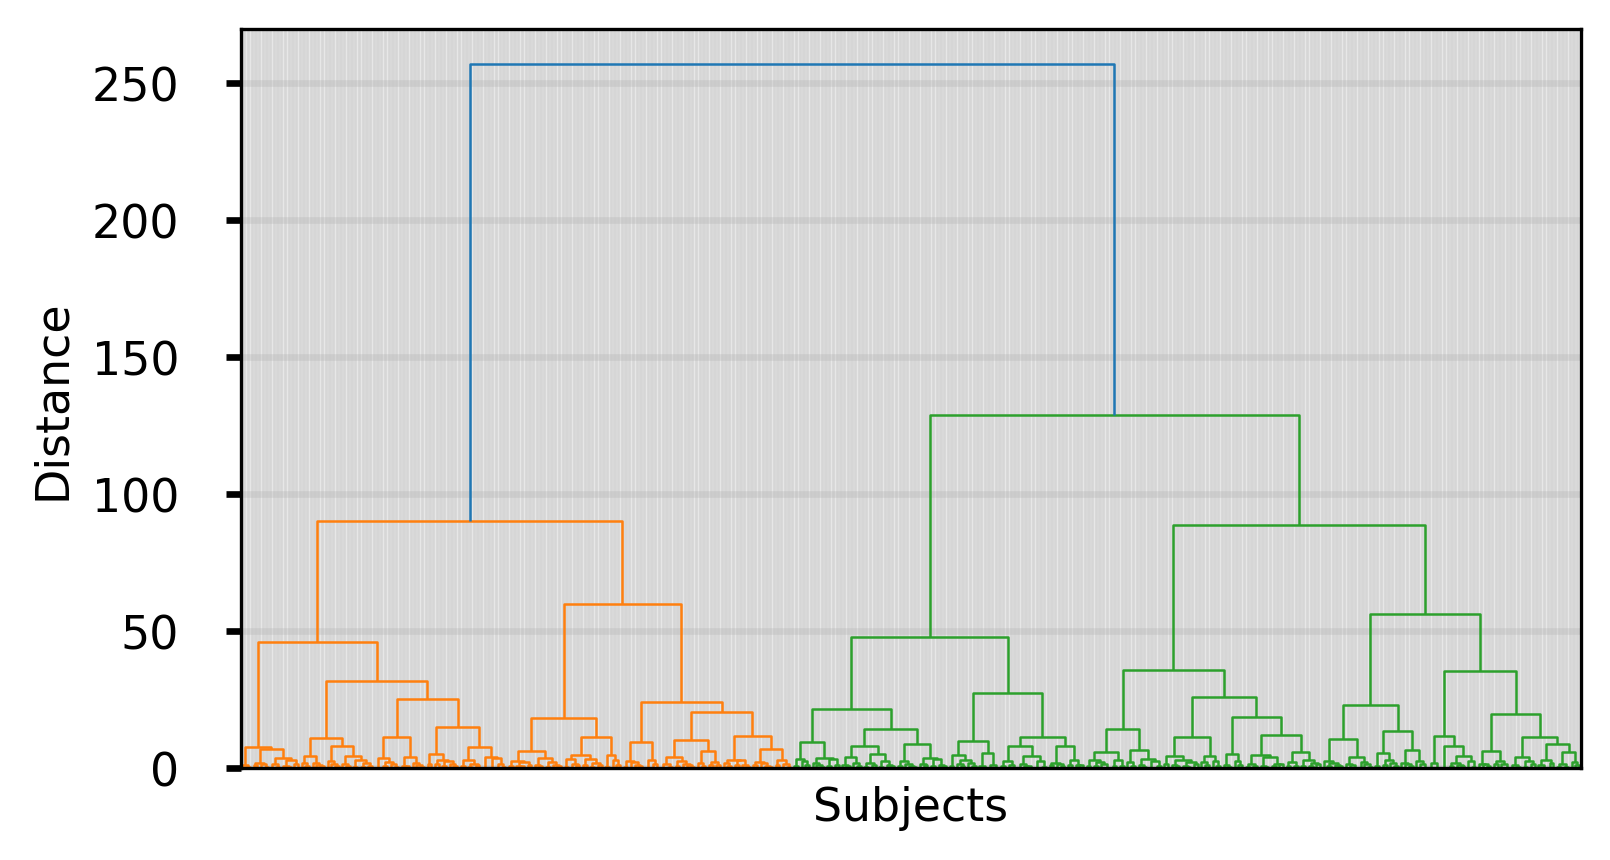

In [86]:
from sklearn.metrics import euclidean_distances
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Step 2: Constructing the dissimilarity matrix
dissimilarity_matrix = euclidean_distances(reduced_data)
print(f"Dissimilarity matrix shape: {dissimilarity_matrix.shape}")

# Assuming 'dissimilarity_matrix' is your uncondensed distance matrix
# Convert the uncondensed distance matrix to a condensed form
condensed_dissimilarity_matrix = squareform(dissimilarity_matrix)
# Step 3: Hierarchical Clustering with Ward's method
# Perform hierarchical clustering using the condensed distance matrix
linkage_matrix = linkage(condensed_dissimilarity_matrix, method='ward')

# Assign initial cluster labels (e.g., 5 clusters)
num_clusters = 5
initial_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Calculate centroids of each cluster
centroids = np.array([data[initial_labels == i].mean(axis=0) for i in range(1, num_clusters + 1)])

# Compute pairwise distances between centroids
centroid_distances = cdist(centroids, centroids, metric='euclidean')

# Calculate average within-cluster distance
within_cluster_distances = []
for i in range(1, num_clusters + 1):
    cluster_points = data[initial_labels == i]
    pairwise_distances = cdist(cluster_points, cluster_points, metric='euclidean')
    np.fill_diagonal(pairwise_distances, np.nan)  # Ignore diagonal (distance to self)
    avg_distance = np.nanmean(pairwise_distances)
    within_cluster_distances.append(avg_distance)
average_within_cluster_distance = np.mean(within_cluster_distances)

# Set the threshold distance
threshold_distance = 20 * average_within_cluster_distance

# Merge clusters based on centroid distance exceeding the threshold
final_labels = initial_labels.copy()
for i in range(num_clusters):
    for j in range(i + 1, num_clusters):
        if centroid_distances[i, j] < threshold_distance:
            # Merge clusters i and j
            final_labels[initial_labels == j + 1] = i + 1

# Display the final cluster labels
print(f"Number of clusters: {len(np.unique(final_labels))}")
print("Final cluster labels:", final_labels)

# Visualize dendrogram with increased font size
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
fig, ax = plt.subplots(figsize=(5.5, 3), dpi=300)
dendrogram(linkage_matrix)
#plt.title("Hierarchical Clustering Dendrogram", fontsize=fontsize)  # Increase title font size
plt.xlabel("Subjects")  # Increase x-axis label font size
plt.ylabel("Distance")  # Increase y-axis label font size
# Remove x-axis ticks
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid(True, alpha=0.3)
ax = plt.gca()
for collection in ax.collections:
    collection.set_linewidth(0.6)  # Reset to default line width
plt.tight_layout()
plt.savefig('dendrogram_high_res.png')  # Save figure with 300 DPI
plt.show()

In [87]:
final_labels

array([1, 2, 1, 3, 3, 1, 2, 1, 1, 4, 3, 4, 4, 4, 2, 2, 4, 3, 3, 4, 1, 1,
       2, 1, 2, 3, 3, 1, 2, 2, 2, 3, 2, 1, 2, 2, 4, 2, 1, 3, 1, 1, 4, 2,
       1, 1, 3, 1, 3, 1, 3, 3, 4, 3, 1, 2, 3, 1, 1, 1, 2, 4, 1, 1, 1, 2,
       4, 4, 4, 1, 1, 1, 2, 2, 4, 1, 2, 1, 3, 2, 4, 1, 1, 1, 1, 2, 1, 4,
       1, 1, 3, 2, 3, 2, 1, 1, 3, 2, 3, 2, 2, 1, 2, 1, 4, 3, 2, 3, 1, 2,
       4, 3, 4, 1, 4, 1, 3, 1, 4, 1, 1, 3, 4, 4, 1, 1, 3, 1, 4, 2, 4, 4,
       1, 1, 3, 3, 1, 2, 1, 1, 3, 1, 2, 2, 4, 1, 1, 1, 2, 2, 3, 3, 4, 1,
       3, 1, 3, 3, 2, 4, 2, 1, 3, 4, 2, 1, 2, 1, 4, 1, 1, 1, 1, 2, 4, 1,
       4, 4, 1, 1, 3, 1, 2, 1, 1, 3, 1, 2, 2, 4, 4, 1, 2, 3, 4, 3, 4, 3,
       1, 4, 4, 1, 1, 1, 4, 3, 4, 2, 2, 4, 4, 3, 3, 4, 1, 1, 2, 3, 1, 1,
       1, 4, 4, 1, 1, 2, 1, 1, 4, 3, 1, 1, 2, 1, 2, 1, 4, 1, 3, 1, 1, 1,
       4, 2, 1, 1, 3, 1, 1, 2, 1, 3, 1, 2, 1, 4, 1, 3, 1, 2, 4, 2, 1, 4,
       1, 3, 1, 1, 2, 3, 1, 2, 1, 1, 3, 4, 4, 1, 2, 2, 4, 3, 2, 1, 1, 4,
       1, 1, 3, 1, 1, 3, 1, 3, 2, 1, 1, 4, 3, 3, 2,

In [88]:
df_CA = df_ah.loc[df_ah['Current_Anxiety']==True].copy()
df_CA['type'] = final_labels

In [89]:
summary_ICD10 = df_CA.groupby(['type', 'ICD10']).size().reset_index(name='count')
print(summary_ICD10)
summary_GAD7 = df_CA.groupby(['type']).agg({'GAD7_score': 'mean'}).reset_index()
print(summary_GAD7)
summary_hospital_current_anxiety = df_CA.groupby('type')['hospital_current_anxiety'].mean().reset_index()
print(summary_hospital_current_anxiety)
summary_Self_Reported_Treatment = df_CA.groupby('type')['Self_Reported_Treatment'].mean().reset_index()
print(summary_Self_Reported_Treatment)
summary_Self_Reported_MentalMedicalCondition = df_CA.groupby('type')['Self_Reported_MentalMedicalCondition'].mean().reset_index()
print(summary_Self_Reported_MentalMedicalCondition)

summary_Age = df_CA.groupby('type')['Age'].mean().reset_index()
print(summary_Age)
summary_Sex = df_CA.groupby('type')['Sex'].mean().reset_index()
print(summary_Sex)
summary_IQ = df_CA.groupby('type')['IQ'].mean().reset_index()
print(summary_IQ)
summary_EA = df_CA.groupby('type')['EA'].mean().reset_index()
print(summary_EA)

    type                     ICD10  count
0      1          ['F402', 'F419']      1
1      1                  ['F402']      1
2      1          ['F408', 'F419']      1
3      1  ['F410', 'F412', 'F419']      1
4      1          ['F410', 'F419']      2
5      1                  ['F410']      1
6      1                  ['F411']      1
7      1          ['F412', 'F419']      1
8      1                  ['F412']      2
9      1                  ['F419']     11
10     1                        []    127
11     2          ['F412', 'F419']      1
12     2                  ['F412']      2
13     2                  ['F419']     12
14     2                        []     64
15     3          ['F401', 'F411']      1
16     3                  ['F402']      1
17     3          ['F412', 'F419']      1
18     3                  ['F412']      1
19     3                  ['F419']      6
20     3                        []     54
21     4                  ['F402']      1
22     4                  ['F410']

In [90]:
#400: Agoraphobia
#401: Social phobias
#402: Specific (isolated) phobias
#408: Other phobic anxiety disorders
#409: Phobic anxiety disorder, unspecified
#410: Panic disorder [episodic paroxysmal anxiety
#411: Generalised anxiety disorder
#412: Mixed anxiety and depressive disorder
#413: Other mixed anxiety disorders
#418: Other specified anxiety disorders
#419: Anxiety disorder, unspecified
summary_ICD10 = df_CA.groupby(['ICD10', 'type']).size().reset_index(name='count')
print(summary_ICD10)

                       ICD10  type  count
0           ['F401', 'F411']     3      1
1           ['F402', 'F419']     1      1
2                   ['F402']     1      1
3                   ['F402']     3      1
4                   ['F402']     4      1
5           ['F408', 'F419']     1      1
6   ['F410', 'F412', 'F419']     1      1
7           ['F410', 'F419']     1      2
8                   ['F410']     1      1
9                   ['F410']     4      1
10                  ['F411']     1      1
11                  ['F411']     4      1
12          ['F412', 'F419']     1      1
13          ['F412', 'F419']     2      1
14          ['F412', 'F419']     3      1
15          ['F412', 'F419']     4      2
16                  ['F412']     1      2
17                  ['F412']     2      2
18                  ['F412']     3      1
19                  ['F412']     4      3
20                  ['F419']     1     11
21                  ['F419']     2     12
22                  ['F419']     3

Interestingly, type 3 have lower diagnose history and treatment history.
Type 3 were with lower IQ and EA

In [91]:
df_CA = df_CA.merge(participantsInfo_df, on='eid', how='left')

In [92]:
order_list = [1, 2, 3, 4]  # your desired order
df_CA['type'] = pd.Categorical(df_CA['type'], categories=order_list, ordered=True)
df_CA = df_CA.sort_values(by='type')

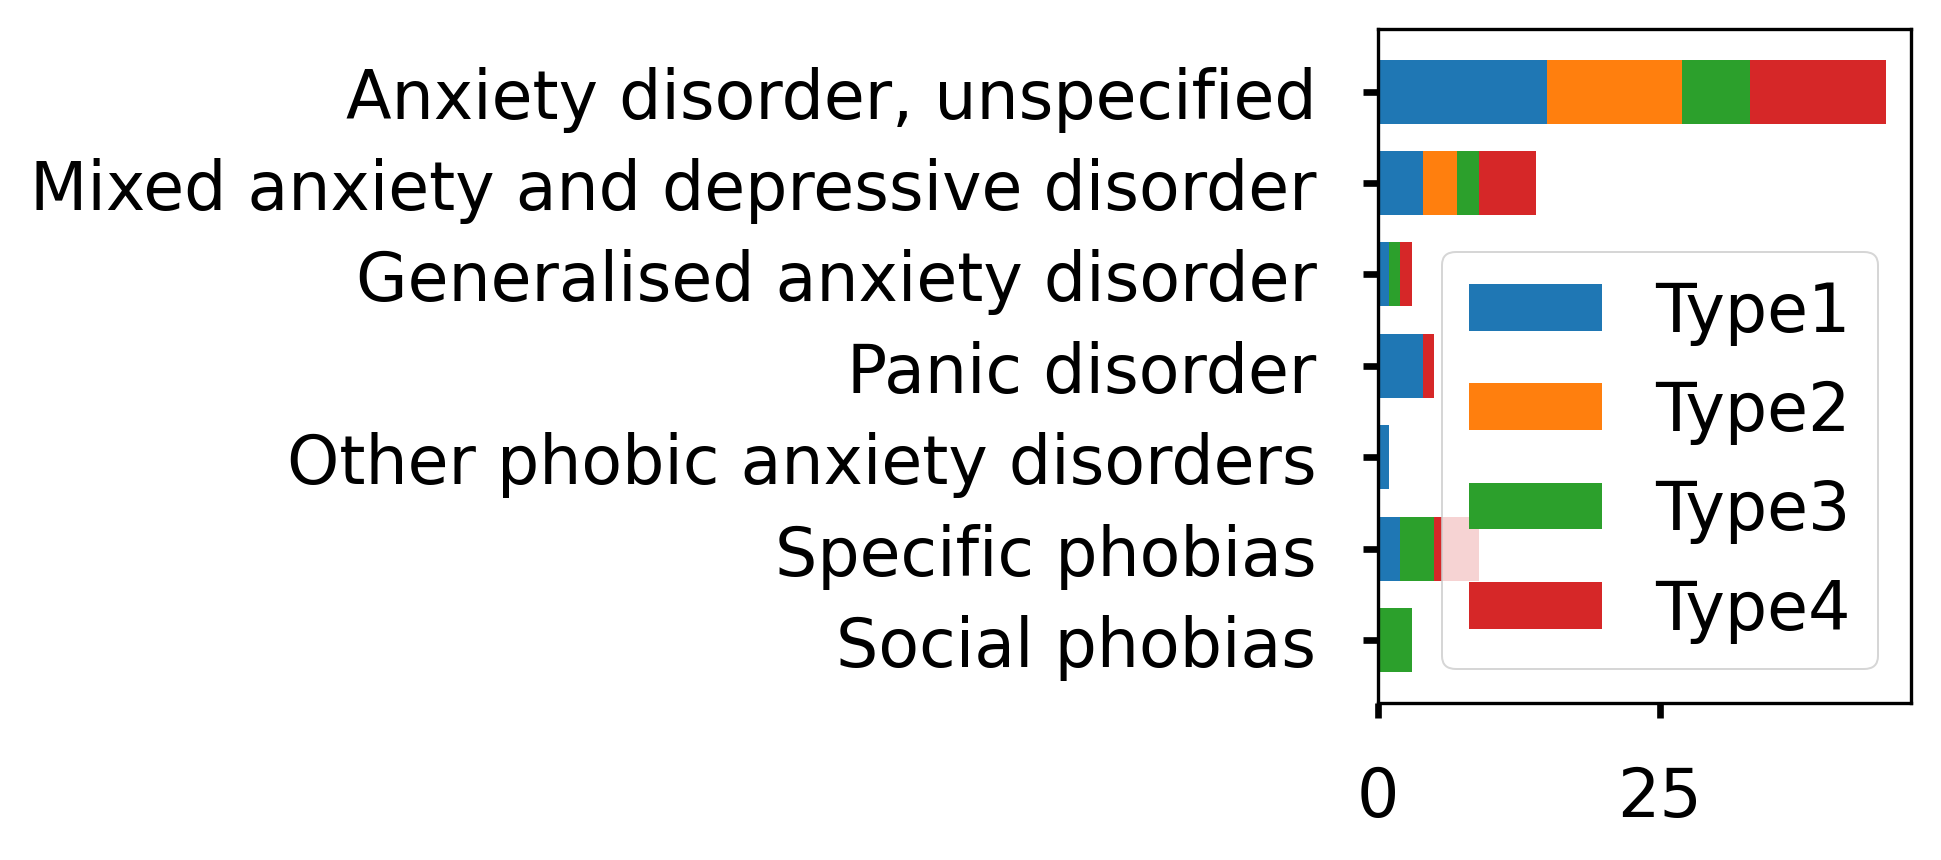

In [93]:
n_in_cluster_df = pd.read_csv('cluster.csv', index_col=0)
df_need = n_in_cluster_df.loc[n_in_cluster_df.index!='No diagnose record']
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({"font.size": fontsize})
fig, ax = plt.subplots(figsize=(6.6, 3), dpi=300)
bar_width = 0.7  # Adjust as needed
y_positions = np.arange(len(df_need.index))
# Plot bars manually for stacked effect
bottom = np.zeros(len(df_need))  # Initialize bottom position for stacking
colors = plt.cm.tab10.colors  # Use default color palette

for i, col in enumerate(df_need.columns):
    ax.barh(y_positions, df_need[col], height=bar_width, left=bottom, label=col, color=colors[i % len(colors)])
    bottom += df_need[col]  # Update bottom for next stack

# Customize axes
ax.set_yticks(y_positions)
ax.set_yticklabels(df_need.index)
ax.set_xlabel("")
ax.set_ylabel("")
#ax.set_frame_on(False)  # Remove bounding box
ax.legend(loc="best")  # Adjust legend
#plt.yticks(rotation=25)
plt.tight_layout()  # Add padding around plot
# Show the plot
plt.savefig('cluster.png')  # Save figure with 300 DPI
plt.show()

In [94]:
import scipy.stats as stats
chi2_stat, p_value, dof, expected = stats.chi2_contingency(df_need)

# Output results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

Chi-Square Statistic: 27.727117041126704
P-value: 0.06633112897142497
Degrees of Freedom: 18
Expected Frequencies: 
[[ 1.0125  0.5625  0.5625  0.8625]
 [ 3.0375  1.6875  1.6875  2.5875]
 [ 0.3375  0.1875  0.1875  0.2875]
 [ 1.6875  0.9375  0.9375  1.4375]
 [ 1.0125  0.5625  0.5625  0.8625]
 [ 4.725   2.625   2.625   4.025 ]
 [15.1875  8.4375  8.4375 12.9375]]


In [95]:
type1 = [item for item, condition in zip(filtered_list_ah, final_labels) if condition == 1]
type2 = [item for item, condition in zip(filtered_list_ah, final_labels) if condition == 2]
type3 = [item for item, condition in zip(filtered_list_ah, final_labels) if condition == 3]
type4 = [item for item, condition in zip(filtered_list_ah, final_labels) if condition == 4]
controls = list(compress(X_ah, ~y_ah))
X_type1 = type1 + controls
true_values = [True] * len(type1)
false_values = [False] * len(controls)
combined_values = true_values + false_values
y_type1 = pd.Series(combined_values)
X_type1 = np.array(X_type1)

X_type2 = type2 + controls
true_values = [True] * len(type2)
combined_values = true_values + false_values
y_type2 = pd.Series(combined_values)
X_type2 = np.array(X_type2)

X_type3 = type3 + controls
true_values = [True] * len(type3)
combined_values = true_values + false_values
y_type3 = pd.Series(combined_values)
X_type3 = np.array(X_type3)

X_type4 = type4 + controls
true_values = [True] * len(type4)
combined_values = true_values + false_values
y_type4 = pd.Series(combined_values)
X_type4 = np.array(X_type4)

In [96]:
n_features = 10
N_random_state = 422
#9 for ah
final_model_data_set1, final_model_data_set2, final_model_data_set3, final_model_data_set4, selected_features_data_set1, selected_features_data_set2, selected_features_data_set3, selected_features_data_set4, weight_type1, weight_type2, weight_type3, weight_type4 = compare_models_and_analyze_topography1(X_type1, y_type1, X_type2, y_type2, X_type3, y_type3, X_type4, y_type4, n_features, N_random_state)

Training data_set1 model...
Model: Logistic Regression, CV Score: 0.6779
Best Model: Logistic Regression with CV score: 0.6779
Model lacks coefficients/feature importance; using univariate feature selection.
Fitting 10 folds for each of 5 candidates, totalling 50 fits


/Users/xiaoqianxiao/PycharmProjects/UKB_structural/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xiaoqianxiao/PycharmProjects/UKB_structural/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters (Broad Search): {'C': 0.01}
Best Parameters (Narrow Search): {'C': np.float64(0.025750000000000002)}
Test Set AUC (Final Model): 0.6085
Test Set Accuracy (Final Model): 0.6495
Confusion Matrix:
 [[63  4]
 [30  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.94      0.79        67
           1       0.00      0.00      0.00        30

    accuracy                           0.65        97
   macro avg       0.34      0.47      0.39        97
weighted avg       0.47      0.65      0.54        97


Training data_set2 model...


/Users/xiaoqianxiao/PycharmProjects/UKB_structural/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xiaoqianxiao/PycharmProjects/UKB_structural/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

Model: Logistic Regression, CV Score: 0.7748
Best Model: Logistic Regression with CV score: 0.7748
Model lacks coefficients/feature importance; using univariate feature selection.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters (Broad Search): {'C': 0.01}
Best Parameters (Narrow Search): {'C': np.float64(0.001)}
Test Set AUC (Final Model): 0.6287
Test Set Accuracy (Final Model): 0.8072
Confusion Matrix:
 [[66  1]
 [15  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89        67
           1       0.50      0.06      0.11        16

    accuracy                           0.81        83
   macro avg       0.66      0.52      0.50        83
weighted avg       0.75      0.81      0.74        83


Training data_set3 model...
Model: Logistic Regression, CV Score: 0.7384
Best Model: Logistic Regression with CV score: 0.7384
Mode

/Users/xiaoqianxiao/PycharmProjects/UKB_structural/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xiaoqianxiao/PycharmProjects/UKB_structural/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters (Broad Search): {'C': 0.01}
Best Parameters (Narrow Search): {'C': np.float64(0.025750000000000002)}
Test Set AUC (Final Model): 0.6234
Test Set Accuracy (Final Model): 0.8250
Confusion Matrix:
 [[66  1]
 [13  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.90        67
           1       0.00      0.00      0.00        13

    accuracy                           0.82        80
   macro avg       0.42      0.49      0.45        80
weighted avg       0.70      0.82      0.76        80


Training data_set4 model...
Model: Logistic Regression, CV Score: 0.7762
Best Model: Logistic Regression with CV score: 0.7762
Model lacks coefficients/feature importance; using univariate feature selection.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters (Broad Sear

/Users/xiaoqianxiao/PycharmProjects/UKB_structural/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xiaoqianxiao/PycharmProjects/UKB_structural/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

In [97]:
df_selected_features_type1 = df_roi_combinations.iloc[selected_features_data_set1]
df_selected_features_type1.loc[:, 'weight'] = weight_type1
df_selected_features_type1['ROI'] = df_selected_features_type1['ROI1'] + 'T' + df_selected_features_type1['ROI2']
print(df_selected_features_type1)
df_selected_features_type2 = df_roi_combinations.iloc[selected_features_data_set2]
df_selected_features_type2.loc[:, 'weight'] = weight_type2
df_selected_features_type2['ROI'] = df_selected_features_type2['ROI1'] + 'T' + df_selected_features_type2['ROI2']
print(df_selected_features_type2)
df_selected_features_type3 = df_roi_combinations.iloc[selected_features_data_set3]
df_selected_features_type3.loc[:, 'weight'] = weight_type3
df_selected_features_type3['ROI'] = df_selected_features_type3['ROI1'] + 'T' + df_selected_features_type3['ROI2']
print(df_selected_features_type3)
df_selected_features_type4 = df_roi_combinations.iloc[selected_features_data_set4]
df_selected_features_type4.loc[:, 'weight'] = weight_type4
df_selected_features_type4['ROI'] = df_selected_features_type4['ROI1'] + 'T' + df_selected_features_type4['ROI2']
print(df_selected_features_type4)

         ROI1     ROI2    weight              ROI
24   rh_dlPFC   rh_AMY  0.015330  rh_dlPFCTrh_AMY
99     rh_Ins   rh_AMY -0.030104    rh_InsTrh_AMY
117    rh_AMY  rh_pTHA  0.000576   rh_AMYTrh_pTHA
118    rh_AMY  rh_aTHA -0.008240   rh_AMYTrh_aTHA
119    rh_AMY   rh_Nac -0.000535    rh_AMYTrh_Nac
125   rh_pTHA  rh_aTHA  0.001310  rh_pTHATrh_aTHA
147    lh_AMY  lh_pTHA -0.001049   lh_AMYTlh_pTHA
148    lh_AMY  lh_aTHA  0.003159   lh_AMYTlh_aTHA
149    lh_AMY   lh_Nac -0.002873    lh_AMYTlh_Nac
150   lh_pTHA  lh_aTHA -0.000707  lh_pTHATlh_aTHA
         ROI1      ROI2    weight                ROI
0    lh_dlPFC  rh_dlPFC -0.020252  lh_dlPFCTrh_dlPFC
2    lh_dlPFC   rh_mPFC -0.002065   lh_dlPFCTrh_mPFC
13   lh_dlPFC    lh_AMY -0.000579    lh_dlPFCTlh_AMY
53    rh_mPFC    rh_AMY -0.027634     rh_mPFCTrh_AMY
78     rh_PCC    rh_AMY -0.037367      rh_PCCTrh_AMY
99     rh_Ins    rh_AMY  0.014981      rh_InsTrh_AMY
108    rh_HIP    rh_AMY -0.000508      rh_HIPTrh_AMY
117    rh_AMY   rh_pTHA  0

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_73929/2981925748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_features_type1.loc[:, 'weight'] = weight_type1
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_73929/2981925748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_features_type1['ROI'] = df_selected_features_type1['ROI1'] + 'T' + df_selected_features_type1['ROI2']
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_73929/2981925748.py:6: S

In [98]:
import pandas as pd

# Function to align ROIs and generate new DataFrames without modifying the originals
def align_rois_generate_new(df_list):
    aligned_pairs = []  # To store aligned pairs of DataFrames
    
    # Iterate over all pairs of DataFrames
    for i in range(len(df_list)):
        for j in range(i + 1, len(df_list)):
            # Get the two DataFrames
            df1, df2 = df_list[i], df_list[j]
            
            # Combine all unique ROIs from both DataFrames
            all_rois = pd.Index(df1['ROI']).union(df2['ROI'])
            
            # Create new aligned DataFrames
            aligned_df1 = df1.set_index('ROI').reindex(all_rois, fill_value=0).reset_index()
            aligned_df2 = df2.set_index('ROI').reindex(all_rois, fill_value=0).reset_index()
            
            # Append the pair of aligned DataFrames to the list
            aligned_pairs.append((aligned_df1, aligned_df2))
    
    return aligned_pairs


df_list = [df_selected_features_type1, df_selected_features_type2, df_selected_features_type3, df_selected_features_type4]

# Call the function
aligned_pairs = align_rois_generate_new(df_list)

# Print results
list_cosine_similarity = []
from sklearn.metrics.pairwise import cosine_similarity
for idx, (df_a, df_b) in enumerate(aligned_pairs):
    #print(f"Aligned Pair {idx + 1} - DataFrame 1:")
    #print(df_a, "\n")
    #print(f"Aligned Pair {idx + 1} - DataFrame 2:")
    #print(df_b, "\n")
    vector1 = df_a['weight'].values.reshape(1, -1)
    vector2 = df_b['weight'].values.reshape(1, -1)
    s = round(cosine_similarity(vector1, vector2)[0][0],3)
    list_cosine_similarity.append(s)

In [99]:
print(list_cosine_similarity)

[np.float64(-0.243), np.float64(0.0), np.float64(-0.001), np.float64(0.0), np.float64(0.0), np.float64(-0.001)]


In [100]:
df_selected_features_type1

,ROI1,ROI2,weight,ROI
24,rh_dlPFC,rh_AMY,0.015330,rh_dlPFCTrh_AMY
99,rh_Ins,rh_AMY,-0.030104,rh_InsTrh_AMY
117,rh_AMY,rh_pTHA,0.000576,rh_AMYTrh_pTHA
118,rh_AMY,rh_aTHA,-0.008240,rh_AMYTrh_aTHA
119,rh_AMY,rh_Nac,-0.000535,rh_AMYTrh_Nac
125,rh_pTHA,rh_aTHA,0.001310,rh_pTHATrh_aTHA
147,lh_AMY,lh_pTHA,-0.001049,lh_AMYTlh_pTHA
148,lh_AMY,lh_aTHA,0.003159,lh_AMYTlh_aTHA
149,lh_AMY,lh_Nac,-0.002873,lh_AMYTlh_Nac
150,lh_pTHA,lh_aTHA,-0.000707,lh_pTHATlh_aTHA


In [101]:
df_selected_features_type2

,ROI1,ROI2,weight,ROI
0,lh_dlPFC,rh_dlPFC,-0.020252,lh_dlPFCTrh_dlPFC
2,lh_dlPFC,rh_mPFC,-0.002065,lh_dlPFCTrh_mPFC
13,lh_dlPFC,lh_AMY,-0.000579,lh_dlPFCTlh_AMY
53,rh_mPFC,rh_AMY,-0.027634,rh_mPFCTrh_AMY
78,rh_PCC,rh_AMY,-0.037367,rh_PCCTrh_AMY
99,rh_Ins,rh_AMY,0.014981,rh_InsTrh_AMY
108,rh_HIP,rh_AMY,-0.000508,rh_HIPTrh_AMY
117,rh_AMY,rh_pTHA,0.001087,rh_AMYTrh_pTHA
143,lh_HIP,lh_AMY,-0.000949,lh_HIPTlh_AMY
147,lh_AMY,lh_pTHA,0.001093,lh_AMYTlh_pTHA


In [102]:
df_selected_features_type3

,ROI1,ROI2,weight,ROI
9,lh_dlPFC,rh_pTHA,0.000764,lh_dlPFCTrh_pTHA
29,rh_dlPFC,lh_AMY,-0.014034,rh_dlPFCTlh_AMY
82,rh_PCC,lh_HIP,-0.132314,rh_PCCTlh_HIP
86,rh_PCC,lh_Nac,-0.077897,rh_PCCTlh_Nac
90,lh_Ins,rh_pTHA,-0.067966,lh_InsTrh_pTHA
98,rh_Ins,rh_HIP,0.018845,rh_InsTrh_HIP
106,rh_Ins,lh_aTHA,-0.095129,rh_InsTlh_aTHA
114,rh_HIP,lh_pTHA,-0.013580,rh_HIPTlh_pTHA
137,rh_aTHA,lh_Nac,-0.117143,rh_aTHATlh_Nac
138,rh_Nac,lh_HIP,-0.052715,rh_NacTlh_HIP


In [103]:
df_selected_features_type4

,ROI1,ROI2,weight,ROI
28,rh_dlPFC,lh_HIP,0.156882,rh_dlPFCTlh_HIP
108,rh_HIP,rh_AMY,-0.001267,rh_HIPTrh_AMY
109,rh_HIP,rh_pTHA,0.000209,rh_HIPTrh_pTHA
114,rh_HIP,lh_pTHA,0.003296,rh_HIPTlh_pTHA
118,rh_AMY,rh_aTHA,0.000782,rh_AMYTrh_aTHA
119,rh_AMY,rh_Nac,-0.000226,rh_AMYTrh_Nac
125,rh_pTHA,rh_aTHA,0.000390,rh_pTHATrh_aTHA
126,rh_pTHA,rh_Nac,-0.000244,rh_pTHATrh_Nac
145,lh_HIP,lh_aTHA,0.000400,lh_HIPTlh_aTHA
150,lh_pTHA,lh_aTHA,0.000127,lh_pTHATlh_aTHA


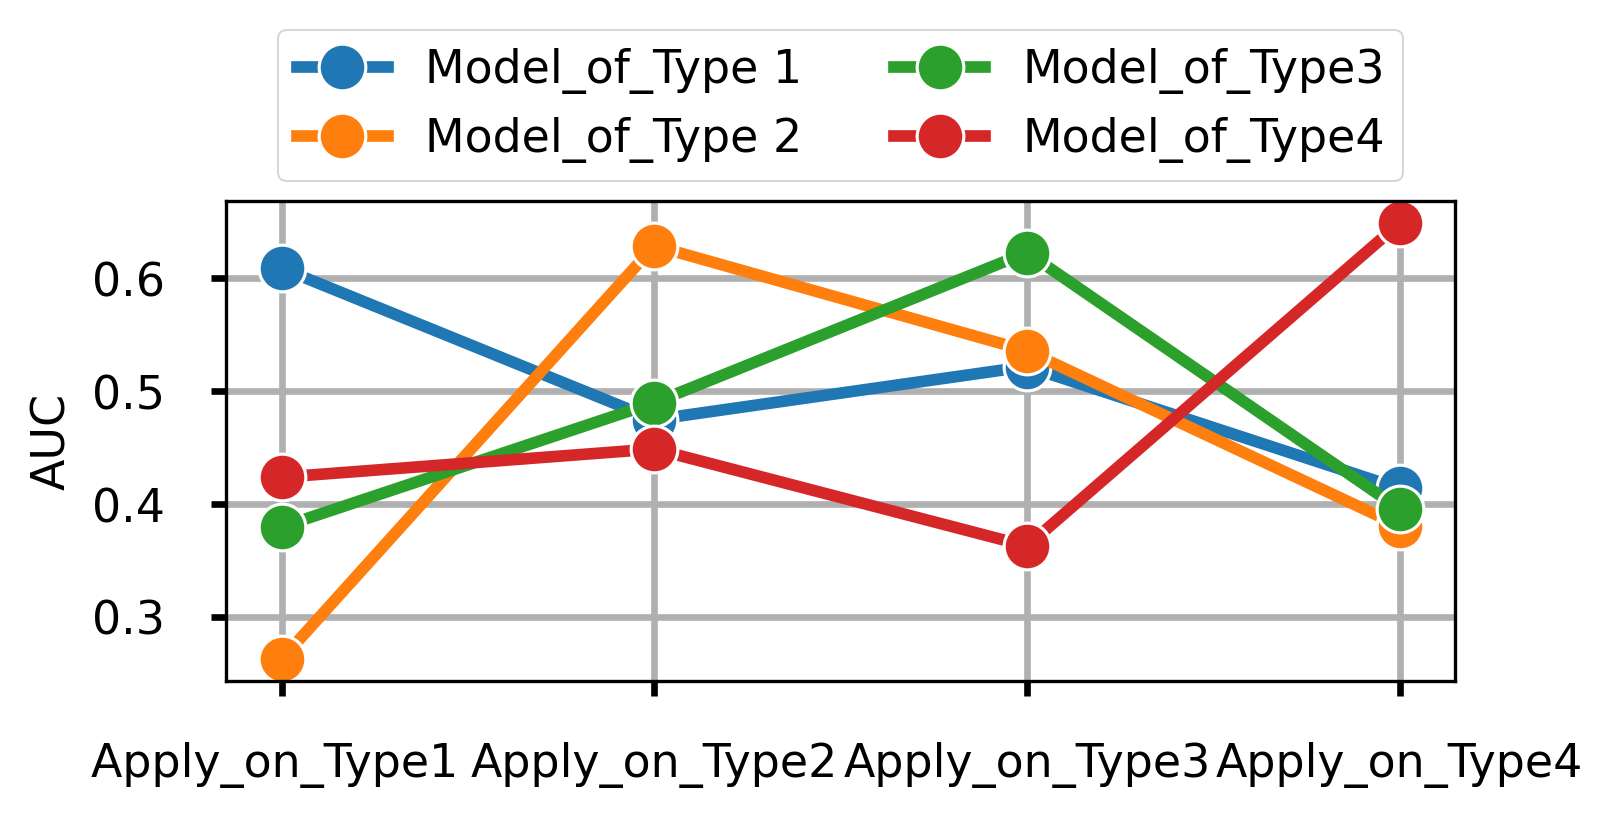

In [104]:
df_results = pd.read_csv('compare_results.csv',index_col=0)
import seaborn as sns
import matplotlib.pyplot as plt

## Transpose the DataFrame for proper line plotting
#df_t = df_results.transpose()
df_t = df_results.copy()
df_t['Apply_to'] = df_t.index  # Add Type as a column for x-axis
df_t.reset_index(drop=True, inplace=True)

# Melt the DataFrame to long-form for Seaborn
df_melted = df_t.melt(id_vars="Apply_to", var_name="Application", value_name="AUC")

# Create the line plot
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
fig, ax = plt.subplots(figsize=(5.5, 3), dpi=300)
sns.lineplot(data=df_melted, x="Apply_to", y="AUC", hue="Application", marker="o", ax=ax)

# Customize the plot
#plt.title("Figure 4. AUC Performance Across Applications")
plt.xlabel("")
plt.ylabel("AUC")

# Customize the legend position
plt.legend(bbox_to_anchor=(0.5, 1.2), loc="center", ncol=2, fontsize=fontsize)
#ax.legend(loc="best")  # Adjust legend
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.savefig('lineplot_model1.png')  # Save figure with 300 DPI
plt.show()

In [105]:
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

def delong_roc_test(y_true, auc1, auc2):
    se = ((auc1 * (1 - auc1)) + (auc2 * (1 - auc2))) / len(y_true)
    z = (auc1 - auc2) / (se ** 0.5)
    p_value = norm.sf(abs(z)) * 2  # Two-tailed test
    return p_value

In [106]:
df_results
true_ys = [y_type1, y_type2, y_type3, y_type4]
types = [1, 2, 3, 4]
print(df_results)

                 Model_of_Type 1  Model_of_Type 2  Model_of_Type3  \
Apply_on_Type1             0.609            0.263           0.380   
Apply_on_Type2             0.475            0.629           0.490   
Apply_on_Type3             0.522            0.536           0.623   
Apply_on_Type4             0.414            0.381           0.396   

                 Model_of_Type4  
Apply_on_Type1            0.424  
Apply_on_Type2            0.449  
Apply_on_Type3            0.363  
Apply_on_Type4            0.649  


In [107]:
# model trained for certain type vs apply that model to another type
p_val = pd.DataFrame(columns=["Model_trained", "Model_apply_to_1", "Model_apply_to_2","pValue"])

for t in range(len(types)):
    true_y = true_ys[t]
    auc1 = df_results.iloc[t, t]    
    for ni in range(len(df_results.index)):
        i = df_results.index[ni]
        ct = df_results.columns[t]
        auc2 = df_results.loc[i, ct]
        row = t*len(types) + ni
        p_val.loc[row, 'pValue'] = round((delong_roc_test(true_y, auc1, auc2) * 16),0) 
        p_val.loc[row, 'Model_trained'] = ct
        p_val.loc[row, 'Model_apply_to_1'] = df_results.index[t]
        p_val.loc[row, 'Model_apply_to_2'] = i
p_val.to_csv('p_val.csv')
print(p_val.shape)

(16, 4)


In [108]:
# model trained for current type vs model train from other type applied on current type
p_val = pd.DataFrame(columns=["Model_apply_to", "Model_trained_1", "Model_trained_2","pValue"])

for t in range(len(types)):
    true_y = true_ys[t]
    auc1 = df_results.iloc[t, t] 
    it = df_results.index[t]
    for nc in range(len(df_results.columns)):
        c = df_results.columns[nc]
        auc2 = df_results.loc[it, c]
        row = t*len(types) + nc
        p_val.loc[row, 'pValue'] = round((delong_roc_test(true_y, auc1, auc2) * 16),0)
        p_val.loc[row, 'Model_apply_to'] = it
        p_val.loc[row, 'Model_trained_1'] = df_results.columns[t]
        p_val.loc[row, 'Model_trained_2'] = c
p_val.to_csv('p_val2.csv')
print(p_val.shape)

(16, 4)


In [109]:
#final_model_data_set1, final_model_data_set2, final_model_data_set3, final_model_data_set4, selected_features_data_set1, selected_features_data_set2, selected_features_data_set3, selected_features_data_set4, weight_type1, weight_type2, weight_type3, weight_type4 = compare_models_and_analyze_topography1(X_type1, y_type1, X_type2, y_type2, X_type3, y_type3, X_type4, y_type4, n_features, N_random_state)
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
perm_importance = permutation_importance(
    final_model_data_set1, X_type1[:, selected_features_data_set1], y_type1, scoring='roc_auc', n_repeats=5000, random_state=422
)
# Create a DataFrame to display permutation importance results
perm_df_type1 = pd.DataFrame({
    "Feature": df_selected_features_type1['ROI'],
    "ROI1": df_selected_features_type1['ROI1'],
    "ROI2": df_selected_features_type1['ROI2'],
    "Importance Mean": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print("\nPermutation Importance (using AUC) for Type1:")
print(perm_df_type1)


Permutation Importance (using AUC) for Type1:
             Feature      ROI1     ROI2  Importance Mean  Importance Std
118   rh_AMYTrh_aTHA    rh_AMY  rh_aTHA         0.176034        0.022510
147   lh_AMYTlh_pTHA    lh_AMY  lh_pTHA         0.115146        0.018392
149    lh_AMYTlh_Nac    lh_AMY   lh_Nac         0.058799        0.012177
150  lh_pTHATlh_aTHA   lh_pTHA  lh_aTHA         0.051203        0.010004
99     rh_InsTrh_AMY    rh_Ins   rh_AMY         0.031743        0.008600
119    rh_AMYTrh_Nac    rh_AMY   rh_Nac         0.005518        0.002201
148   lh_AMYTlh_aTHA    lh_AMY  lh_aTHA        -0.009269        0.007424
24   rh_dlPFCTrh_AMY  rh_dlPFC   rh_AMY        -0.010563        0.009985
117   rh_AMYTrh_pTHA    rh_AMY  rh_pTHA        -0.013002        0.007255
125  rh_pTHATrh_aTHA   rh_pTHA  rh_aTHA        -0.019855        0.010953


In [110]:
perm_importance = permutation_importance(
    final_model_data_set2, X_type2[:, selected_features_data_set2], y_type2, scoring='roc_auc', n_repeats=5000, random_state=422
)
# Create a DataFrame to display permutation importance results
perm_df_type2 = pd.DataFrame({
    "Feature": df_selected_features_type2['ROI'],
    "ROI1": df_selected_features_type2['ROI1'],
    "ROI2": df_selected_features_type2['ROI2'],
    "Importance Mean": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print("\nPermutation Importance (using AUC) for Type2:")
print(perm_df_type2)


Permutation Importance (using AUC) for Type2:
               Feature      ROI1      ROI2  Importance Mean  Importance Std
147     lh_AMYTlh_pTHA    lh_AMY   lh_pTHA         0.202080        0.020938
117     rh_AMYTrh_pTHA    rh_AMY   rh_pTHA         0.175507        0.019764
99       rh_InsTrh_AMY    rh_Ins    rh_AMY         0.026403        0.005015
2     lh_dlPFCTrh_mPFC  lh_dlPFC   rh_mPFC        -0.003468        0.000622
13     lh_dlPFCTlh_AMY  lh_dlPFC    lh_AMY        -0.004206        0.000743
108      rh_HIPTrh_AMY    rh_HIP    rh_AMY        -0.032669        0.005586
143      lh_HIPTlh_AMY    lh_HIP    lh_AMY        -0.048433        0.009438
53      rh_mPFCTrh_AMY   rh_mPFC    rh_AMY        -0.070211        0.013518
0    lh_dlPFCTrh_dlPFC  lh_dlPFC  rh_dlPFC        -0.072555        0.011889
78       rh_PCCTrh_AMY    rh_PCC    rh_AMY        -0.126014        0.021418


In [119]:
perm_importance = permutation_importance(
    final_model_data_set3, X_type3[:, selected_features_data_set3], y_type3, scoring='roc_auc', n_repeats=5000, random_state=422
)
# Create a DataFrame to display permutation importance results
perm_df_type3 = pd.DataFrame({
    "Feature": df_selected_features_type3['ROI'],
    "ROI1": df_selected_features_type3['ROI1'],
    "ROI2": df_selected_features_type3['ROI2'],
    "Importance Mean": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print("\nPermutation Importance (using AUC) for Type3:")
print(perm_df_type3)


Permutation Importance (using AUC) for Type3:
              Feature      ROI1     ROI2  Importance Mean  Importance Std
98      rh_InsTrh_HIP    rh_Ins   rh_HIP         0.063507        0.020857
137    rh_aTHATlh_Nac   rh_aTHA   lh_Nac         0.033935        0.015679
114    rh_HIPTlh_pTHA    rh_HIP  lh_pTHA         0.022206        0.013723
82      rh_PCCTlh_HIP    rh_PCC   lh_HIP         0.019479        0.011322
138     rh_NacTlh_HIP    rh_Nac   lh_HIP         0.016311        0.011956
90     lh_InsTrh_pTHA    lh_Ins  rh_pTHA         0.015057        0.013272
106    rh_InsTlh_aTHA    rh_Ins  lh_aTHA         0.014389        0.012400
29    rh_dlPFCTlh_AMY  rh_dlPFC   lh_AMY         0.005972        0.005624
86      rh_PCCTlh_Nac    rh_PCC   lh_Nac         0.002777        0.003076
9    lh_dlPFCTrh_pTHA  lh_dlPFC  rh_pTHA         0.000584        0.000799


In [120]:
perm_importance = permutation_importance(
    final_model_data_set4, X_type4[:, selected_features_data_set4], y_type4, scoring='roc_auc', n_repeats=5000, random_state=422
)
# Create a DataFrame to display permutation importance results
perm_df_type4 = pd.DataFrame({
    "Feature": df_selected_features_type4['ROI'],
    "ROI1": df_selected_features_type4['ROI1'],
    "ROI2": df_selected_features_type4['ROI2'],
    "Importance Mean": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print("\nPermutation Importance (using AUC) for Type4:")
print(perm_df_type4)


Permutation Importance (using AUC) for Type4:
             Feature      ROI1     ROI2  Importance Mean  Importance Std
125  rh_pTHATrh_aTHA   rh_pTHA  rh_aTHA         0.083839        0.013625
28   rh_dlPFCTlh_HIP  rh_dlPFC   lh_HIP         0.074769        0.016305
114   rh_HIPTlh_pTHA    rh_HIP  lh_pTHA         0.043536        0.009537
145   lh_HIPTlh_aTHA    lh_HIP  lh_aTHA         0.037987        0.010000
118   rh_AMYTrh_aTHA    rh_AMY  rh_aTHA         0.030841        0.008353
150  lh_pTHATlh_aTHA   lh_pTHA  lh_aTHA         0.022755        0.004863
109   rh_HIPTrh_pTHA    rh_HIP  rh_pTHA         0.021095        0.005473
119    rh_AMYTrh_Nac    rh_AMY   rh_Nac        -0.007598        0.002388
126   rh_pTHATrh_Nac   rh_pTHA   rh_Nac        -0.019170        0.006820
108    rh_HIPTrh_AMY    rh_HIP   rh_AMY        -0.069275        0.022438


In [112]:
import re
perm_df_type1['bROI1'] = perm_df_type1['ROI1'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
perm_df_type1['bROI2'] = perm_df_type1['ROI2'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
df_long_type1 = pd.melt(perm_df_type1, id_vars=["Importance Mean"], value_vars=["bROI1", "bROI2"], var_name="bROI_from", value_name="bROI")
df_importance_type1 = df_long_type1.groupby(['bROI']).agg({'Importance Mean': 'sum'}).reset_index()
df_importance_type1['type'] = 'type1'
print(df_importance_type1.sort_values(by="Importance Mean", ascending=False))
perm_df_type1['bbROI'] = perm_df_type1['bROI1'] + '_' + perm_df_type1['bROI2']
net_df_type1 = perm_df_type1.groupby('bbROI').agg({'Importance Mean': 'sum'}).reset_index()
net_df_type1['type'] = 'type1'
print(net_df_type1.sort_values(by="Importance Mean", ascending=False))

    bROI  Importance Mean   type
0    AMY         0.354406  type1
3   aTHA         0.198113  type1
5   pTHA         0.133493  type1
2    Nac         0.064317  type1
1    Ins         0.031743  type1
4  dlPFC        -0.010563  type1
       bbROI  Importance Mean   type
1   AMY_aTHA         0.166765  type1
2   AMY_pTHA         0.102144  type1
0    AMY_Nac         0.064317  type1
3    Ins_AMY         0.031743  type1
5  pTHA_aTHA         0.031348  type1
4  dlPFC_AMY        -0.010563  type1


In [122]:
perm_df_type2['bROI1'] = perm_df_type2['ROI1'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
perm_df_type2['bROI2'] = perm_df_type2['ROI2'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
df_long_type2 = pd.melt(perm_df_type2, id_vars=["Importance Mean"], value_vars=["bROI1", "bROI2"], var_name="bROI_from", value_name="bROI")
df_importance_type2 = df_long_type2.groupby(['bROI']).agg({'Importance Mean': 'sum'}).reset_index()
df_importance_type2['type'] = 'type2'
print(df_importance_type2.sort_values(by="Importance Mean", ascending=False))
perm_df_type2['bbROI'] = perm_df_type2['bROI1'] + '_' + perm_df_type2['bROI2']
net_df_type2 = perm_df_type2.groupby('bbROI').agg({'Importance Mean': 'sum'}).reset_index()
net_df_type2['type'] = 'type2'
print(net_df_type2.sort_values(by="Importance Mean", ascending=False))

    bROI  Importance Mean   type
6   pTHA         0.377587  type2
0    AMY         0.122457  type2
2    Ins         0.026403  type2
5   mPFC        -0.073679  type2
1    HIP        -0.081101  type2
3    PCC        -0.126014  type2
4  dlPFC        -0.152784  type2
         bbROI  Importance Mean   type
0     AMY_pTHA         0.377587  type2
2      Ins_AMY         0.026403  type2
6   dlPFC_mPFC        -0.003468  type2
4    dlPFC_AMY        -0.004206  type2
7     mPFC_AMY        -0.070211  type2
5  dlPFC_dlPFC        -0.072555  type2
1      HIP_AMY        -0.081101  type2
3      PCC_AMY        -0.126014  type2


In [123]:
perm_df_type3['bROI1'] = perm_df_type3['ROI1'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
perm_df_type3['bROI2'] = perm_df_type3['ROI2'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
df_long_type3 = pd.melt(perm_df_type3, id_vars=["Importance Mean"], value_vars=["bROI1", "bROI2"], var_name="bROI_from", value_name="bROI")
df_importance_type3 = df_long_type3.groupby(['bROI']).agg({'Importance Mean': 'sum'}).reset_index()
df_importance_type3['type'] = 'type3'
print(df_importance_type3.sort_values(by="Importance Mean", ascending=False))
perm_df_type3['bbROI'] = perm_df_type3['bROI1'] + '_' + perm_df_type3['bROI2']
net_df_type3 = perm_df_type3.groupby('bbROI').agg({'Importance Mean': 'sum'}).reset_index()
net_df_type3['type'] = 'type3'
print(net_df_type3.sort_values(by="Importance Mean", ascending=False))

    bROI  Importance Mean   type
1    HIP         0.121504  type3
2    Ins         0.092953  type3
3    Nac         0.053023  type3
5   aTHA         0.048324  type3
7   pTHA         0.037847  type3
4    PCC         0.022257  type3
6  dlPFC         0.006556  type3
0    AMY         0.005972  type3
        bbROI  Importance Mean   type
1     Ins_HIP         0.063507  type3
7    aTHA_Nac         0.033935  type3
0    HIP_pTHA         0.022206  type3
5     PCC_HIP         0.019479  type3
4     Nac_HIP         0.016311  type3
3    Ins_pTHA         0.015057  type3
2    Ins_aTHA         0.014389  type3
8   dlPFC_AMY         0.005972  type3
6     PCC_Nac         0.002777  type3
9  dlPFC_pTHA         0.000584  type3


In [116]:
perm_df_type4['bROI1'] = perm_df_type4['ROI1'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
perm_df_type4['bROI2'] = perm_df_type4['ROI2'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
df_long_type4 = pd.melt(perm_df_type4, id_vars=["Importance Mean"], value_vars=["bROI1", "bROI2"], var_name="bROI_from", value_name="bROI")
df_importance_type4 = df_long_type4.groupby(['bROI']).agg({'Importance Mean': 'sum'}).reset_index()
df_importance_type4['type'] = 'type4'
print(df_importance_type4.sort_values(by="Importance Mean", ascending=False))
perm_df_type4['bbROI'] = perm_df_type4['bROI1'] + '_' + perm_df_type4['bROI2']
net_df_type4 = perm_df_type4.groupby('bbROI').agg({'Importance Mean': 'sum'}).reset_index()
net_df_type4['type'] = 'type4'
print(net_df_type4.sort_values(by="Importance Mean", ascending=False))

    bROI  Importance Mean   type
3   aTHA         0.175422  type4
5   pTHA         0.152054  type4
1    HIP         0.108111  type4
4  dlPFC         0.074769  type4
2    Nac        -0.026768  type4
0    AMY        -0.046033  type4
       bbROI  Importance Mean   type
7  pTHA_aTHA         0.106594  type4
5  dlPFC_HIP         0.074769  type4
4   HIP_pTHA         0.064631  type4
3   HIP_aTHA         0.037987  type4
1   AMY_aTHA         0.030841  type4
0    AMY_Nac        -0.007598  type4
6   pTHA_Nac        -0.019170  type4
2    HIP_AMY        -0.069275  type4


In [124]:
df_importance = pd.concat([df_importance_type1, df_importance_type2, df_importance_type3, df_importance_type4], axis=0)
print(df_importance)

    bROI  Importance Mean   type
0    AMY         0.354406  type1
1    Ins         0.031743  type1
2    Nac         0.064317  type1
3   aTHA         0.198113  type1
4  dlPFC        -0.010563  type1
5   pTHA         0.133493  type1
0    AMY         0.122457  type2
1    HIP        -0.081101  type2
2    Ins         0.026403  type2
3    PCC        -0.126014  type2
4  dlPFC        -0.152784  type2
5   mPFC        -0.073679  type2
6   pTHA         0.377587  type2
0    AMY         0.005972  type3
1    HIP         0.121504  type3
2    Ins         0.092953  type3
3    Nac         0.053023  type3
4    PCC         0.022257  type3
5   aTHA         0.048324  type3
6  dlPFC         0.006556  type3
7   pTHA         0.037847  type3
0    AMY        -0.046033  type4
1    HIP         0.108111  type4
2    Nac        -0.026768  type4
3   aTHA         0.175422  type4
4  dlPFC         0.074769  type4
5   pTHA         0.152054  type4


In [125]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

# Assuming df_importance is already loaded

# Explicitly order the types
types_ordered = ["type1", "type2", "type3", "type4"]  # Enforce desired type order
brois_ordered = df_importance['bROI'].unique().tolist()  # Keep bROIs in natural order
labels_ordered = types_ordered + brois_ordered  # Combined label list

# Map source and target indices based on ordered labels
df_importance['source'] = df_importance['type'].apply(lambda x: types_ordered.index(x))
df_importance['target'] = df_importance['bROI'].apply(lambda x: len(types_ordered) + brois_ordered.index(x))

# Define y positions to control vertical placement (types at y=1, bROIs at y=0)
type_y_positions = [1] * len(types_ordered)  # High y for types
broi_y_positions = [0] * len(brois_ordered)  # Low y for bROIs
node_y_positions = type_y_positions + broi_y_positions  # Combine

# Define x positions to control horizontal placement (types at x=0, bROIs at x=1)
node_x_positions = [0] * len(types_ordered) + [1] * len(brois_ordered)

# Define link colors based on type
link_colors = df_importance['type'].map({
    "type1": "blue",
    "type2": "orange",
    "type3": "green",
    "type4": "red"
})

# Use a different color palette (Viridis) for the target (bROI) nodes
target_colors = px.colors.qualitative.Dark24
# Ensure that the number of colors matches the number of bROIs
target_colors = target_colors[:len(brois_ordered)]

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels_ordered,
        color=["blue", "orange", "green", "red"] + target_colors,  # Color for types and unique bROIs
        x=node_x_positions,  # Control x position
        y=node_y_positions,  # Control y position for vertical placement
    ),
    link=dict(
        source=df_importance['source'],
        target=df_importance['target'],
        value=df_importance['Importance Mean'],
        color=link_colors.tolist(),  # Link colors based on source (type)
    )
))

# Update layout to control node arrangement and figure size
fig.update_layout(
    #title_text="Sankey Diagram",
    font_size=fontsize,
    xaxis=dict(showgrid=False, zeroline=False),  # Hide gridlines for x-axis
    yaxis=dict(showgrid=False, zeroline=False),  # Hide gridlines for y-axis
    width=600,  # 12 inches in pixels (at 100 DPI)
    height=600,  # 6 inches in pixels (at 100 DPI)
)
#fig.write_image("sankey_diagram_with_target_colors.png", scale=3) 
# Show the figure (no saving)
fig.show()


In [126]:
#circular plot
df_importance_net = pd.concat([net_df_type1, net_df_type2, net_df_type3, net_df_type4], axis=0)
df_importance_net['ROI1'] = df_importance_net['bbROI'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,0]
df_importance_net['ROI2'] = df_importance_net['bbROI'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
print(df_importance_net)

         bbROI  Importance Mean   type   ROI1   ROI2
0      AMY_Nac         0.064317  type1    AMY    Nac
1     AMY_aTHA         0.166765  type1    AMY   aTHA
2     AMY_pTHA         0.102144  type1    AMY   pTHA
3      Ins_AMY         0.031743  type1    Ins    AMY
4    dlPFC_AMY        -0.010563  type1  dlPFC    AMY
5    pTHA_aTHA         0.031348  type1   pTHA   aTHA
0     AMY_pTHA         0.377587  type2    AMY   pTHA
1      HIP_AMY        -0.081101  type2    HIP    AMY
2      Ins_AMY         0.026403  type2    Ins    AMY
3      PCC_AMY        -0.126014  type2    PCC    AMY
4    dlPFC_AMY        -0.004206  type2  dlPFC    AMY
5  dlPFC_dlPFC        -0.072555  type2  dlPFC  dlPFC
6   dlPFC_mPFC        -0.003468  type2  dlPFC   mPFC
7     mPFC_AMY        -0.070211  type2   mPFC    AMY
0     HIP_pTHA         0.022206  type3    HIP   pTHA
1      Ins_HIP         0.063507  type3    Ins    HIP
2     Ins_aTHA         0.014389  type3    Ins   aTHA
3     Ins_pTHA         0.015057  type3    Ins 

In [127]:
df_importance_net_positive = df_importance_net.loc[df_importance_net['Importance Mean'] > 0]
df_importance_net_positive['Importance'] = df_importance_net_positive['Importance Mean'] * 100

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_73929/1935040764.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [199]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
df_sorted = df_importance_net_positive.sort_values(by="Importance")

# Define color map for the types
type_colors = {
    'type1': 'blue',
    'type2': 'orange',
    'type3': 'green',
    'type4': 'red'
}
line_styles = {
    'type1': 'solid',  # Solid line for type1
    'type2': 'dash',   # Dashed line for type2
    'type3': 'dot',    # Dotted line for type3
    'type4': 'dashdot' # Dash-dot line for type4
}
# Create the node labels (use ROI1 and ROI2)
unique_rois = pd.concat([df_importance_net_positive['ROI1'], df_importance_net_positive['ROI2']]).unique().tolist()

# Create node positions in a circular layout (with increased radius for clarity)
theta = [i * 2 * np.pi / len(unique_rois) for i in range(len(unique_rois))]
radius = 1.2  # Increase the radius for better spacing
x_positions = [radius * np.cos(t) for t in theta]
y_positions = [radius * np.sin(t) for t in theta]

# Create node positions in a circular layout (with increased radius for clarity)
theta = [i * 2 * np.pi / len(unique_rois) for i in range(len(unique_rois))]
radius = 1.2  # Increase the radius for better spacing
x_positions = [radius * np.cos(t) for t in theta]
y_positions = [radius * np.sin(t) for t in theta]

# Adjust label positions to avoid overlap, with specific adjustments for the first 4 nodes
x_offset = 0.1  # Small offset to the right

# Adjust y_offset for different labels
y_positions_label = []
for i, y in enumerate(y_positions):
    if i < 3:  # First three nodes: move right
        y_positions_label.append(y + 0.1)  # Keep the y positions as they are
        x_positions[i] += 0.25  # Move the first three nodes to the right
    elif i == 3:  # Fourth node: move up
        y_positions_label.append(y + 0.1)  # Move the fourth node upwards
    elif i==7 or i == 8: 
        y_positions_label.append(y - 0.2)
    else:  # For the rest of the nodes, maintain the original offsets
        y_positions_label.append(y)

x_positions_label = [x + x_offset for x in x_positions]
x_positions_label[5] = x_positions_label[5] - 0.4
x_positions_label[6] = x_positions_label[6] - 0.2
x_positions_label[4] = x_positions_label[4] - 0.1

#for i in [5,6]:
#    x_positions_label[i] = x_positions_label[i] - 0.2

# Create source and target mappings based on ROI1 and ROI2 names
source_idx = df_importance_net_positive['ROI1'].apply(lambda x: unique_rois.index(x)).tolist()
target_idx = df_importance_net_positive['ROI2'].apply(lambda x: unique_rois.index(x)).tolist()

# Define link colors based on the type column
link_colors = df_importance_net_positive['type'].map(type_colors).tolist()
link_line_styles = df_importance_net_positive['type'].map(line_styles).tolist()

# Use Dark24 color palette for the nodes
#node_colors = px.colors.qualitative.Dark24[:len(unique_rois)]
node_colors = ['#2F4F4F'] * len(unique_rois)

# Define font size for the labels
fontsize = 14  # You can adjust the font size here

# Create the circular plot using Plotly
fig = go.Figure()

# Add the nodes (with positions and labels)
fig.add_trace(go.Scatter(
    x=x_positions,  # Position on the x-axis for nodes
    y=y_positions,  # Position on the y-axis for nodes
    mode='markers',
    textfont=dict(size=fontsize),  # Set font size for node labels
    marker=dict(
        size=18,
        color=node_colors  # Node color (same for all)
        #line=dict(color='black', width=2)
    ),
    showlegend=False
))

# Add the links between source and target ROIs
for i in range(len(df_importance_net_positive)):
    fig.add_trace(go.Scatter(
        x=[x_positions[source_idx[i]], x_positions[target_idx[i]]],
        y=[y_positions[source_idx[i]], y_positions[target_idx[i]]],
        mode='lines+text',
        #line=dict(color=link_colors[i], width=abs(df_sorted['Importance'].iloc[i]) * 0.8, dash=link_line_styles[i]),
        line=dict(color=link_colors[i], width=abs(df_importance_net_positive['Importance'].iloc[i]) * 0.8),
        opacity=0.4,  # Scale link width by Importance Mean and ensure it's positive
        showlegend=False
    ))
# Add labels at the adjusted positions
fig.add_trace(go.Scatter(
    x=x_positions_label,  # Position on the x-axis for node labels
    y=y_positions_label,  # Position on the y-axis for node labels
    mode='text',
    text=unique_rois,
    textposition='top center',  # Positioning the text labels at the top center
    textfont=dict(size=fontsize),  # Set font size for node labels
    showlegend=False
))
# Add custom legend for link types with different line styles
fig.add_trace(go.Scatter(
    x=[None], y=[None],  # Invisible plot for legend entry
    mode='lines',
    #line=dict(color='blue', width=3, dash='solid'),
    #name='type1 (solid)'
    line=dict(color='blue', width=3, dash='solid'),
    name='type1'
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],  # Invisible plot for legend entry
    mode='lines',
    # line=dict(color='orange', width=3, dash='dash'),
    # name='type2 (dashed)'
    line=dict(color='orange', width=3, dash='solid'),
    name='type2'
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],  # Invisible plot for legend entry
    mode='lines',
    # line=dict(color='green', width=3, dash='dot'),
    # name='type3 (solid)'
    line=dict(color='green', width=3, dash='solid'),
    name='type3'
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],  # Invisible plot for legend entry
    mode='lines',
    # line=dict(color='red', width=3, dash='dashdot'),
    # name='type4 (dash-dot)'
    line=dict(color='red', width=3, dash='solid'),
    name='type4'
))

# Update layout for better visuals
fig.update_layout(
    #title="Circular Plot of Connections Between ROIs",
    font=dict(size=fontsize),  # Set font size for labels
    plot_bgcolor='white',
    width=400, 
    height=380,
    showlegend=True,
    legend=dict(
        orientation='h',  # Horizontal legend
        yanchor='bottom',  # Position at the bottom
        y=-0.1,  # Slightly below the plot
        x=0.5,  # Centered horizontally
        xanchor='center'
    ),
    xaxis=dict(showticklabels=False, zeroline=False),  # Hide x-axis labels and grid
    yaxis=dict(showticklabels=False, zeroline=False),  # Hide y-axis labels and grid
    margin=dict(t=20, b=20, l=20, r=20)  # Adjust margin to make the plot more centered
)

# Show the plot
fig.show()


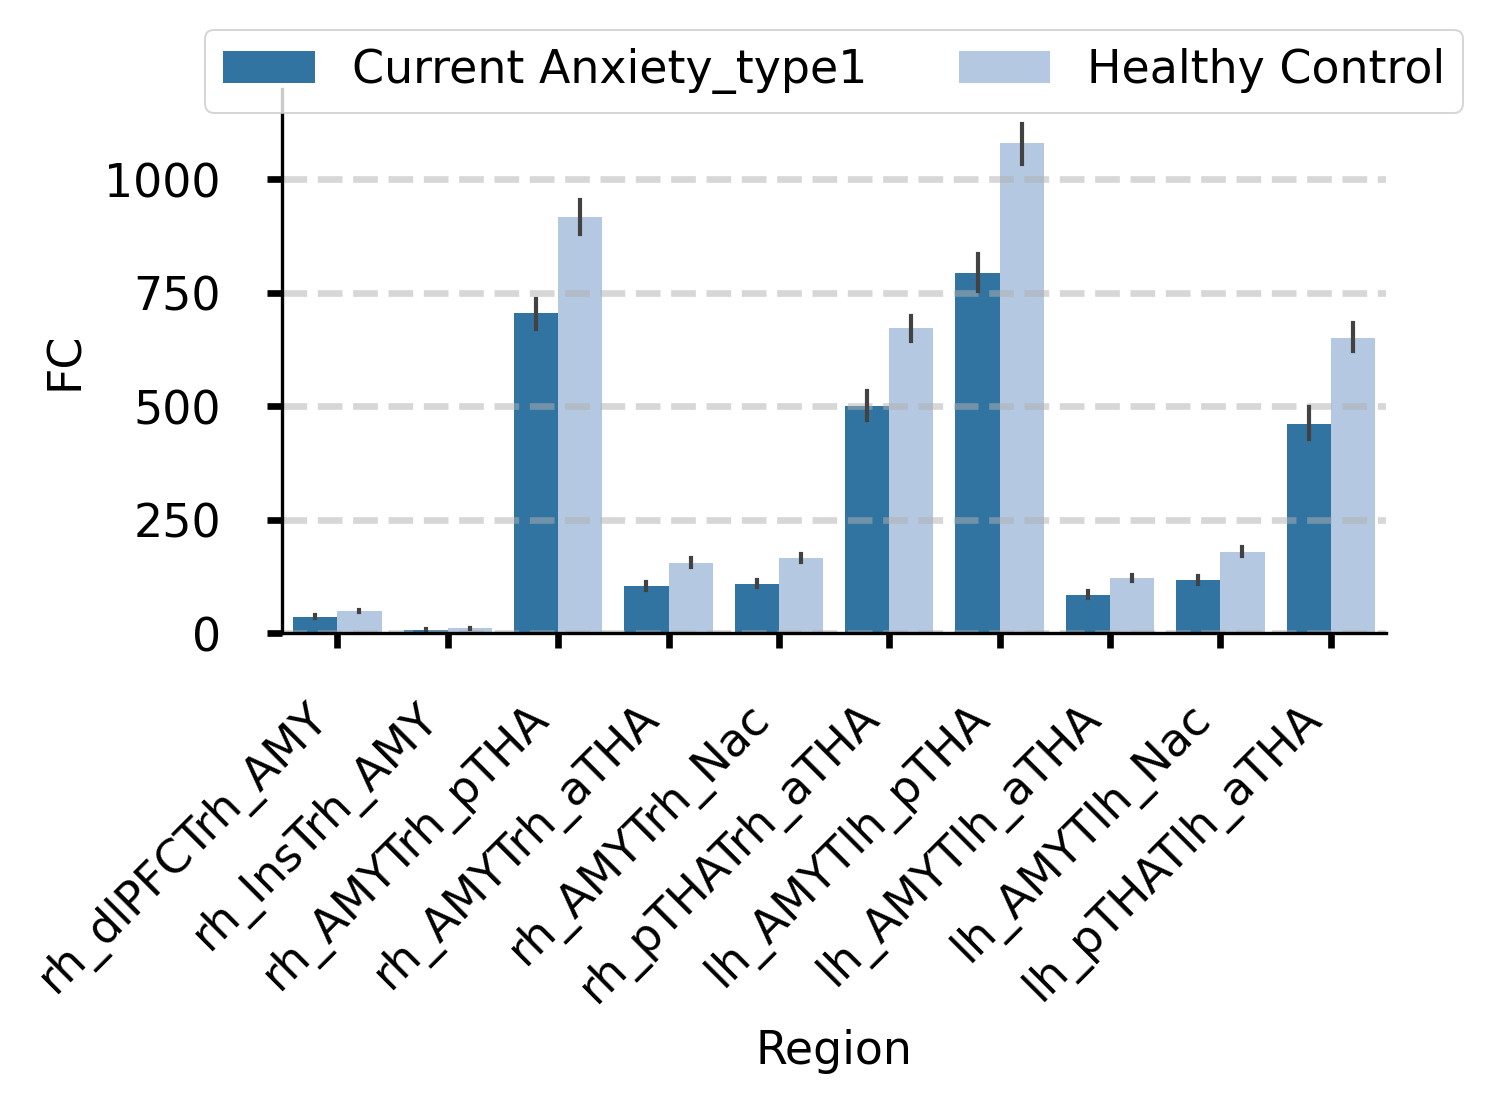

In [141]:
df_bs_type1 = pd.DataFrame(X_type1[:, selected_features_data_set1])
df_bs_type1.columns = list(df_selected_features_type1['ROI'])
df_bs_type1['Anxiety'] = y_type1
# Relabel the 'Anxiety' column
df_bs_type1['Anxiety'] = df_bs_type1['Anxiety'].map({False: 'Healthy Control', True: 'Current Anxiety_type1'})

# Melt the dataframe to long format for seaborn compatibility
df_long = df_bs_type1.melt(id_vars=['Anxiety'], value_vars=df_bs_type1.columns[:-1],
                           var_name='Region', value_name='FC')

# Create a bar plot
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)


# Create bar plot with thinner error bars
sns.barplot(
    x="Region", 
    y="FC", 
    hue="Anxiety", 
    data=df_long, 
    err_kws={"linewidth": 1},  # Thinner error bars
    palette=["#1f77b4", "#aec7e8"],  # Consistent blue/light blue color scheme
    ax=ax
)

# Fix x-tick positions and labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
# Customize plot
legend = plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Keep only y-grid for clarity

sns.despine()
plt.ylim(0, 1200)

plt.tight_layout()

# Save and display the plot
#plt.savefig("bar_model1.png")
plt.show()



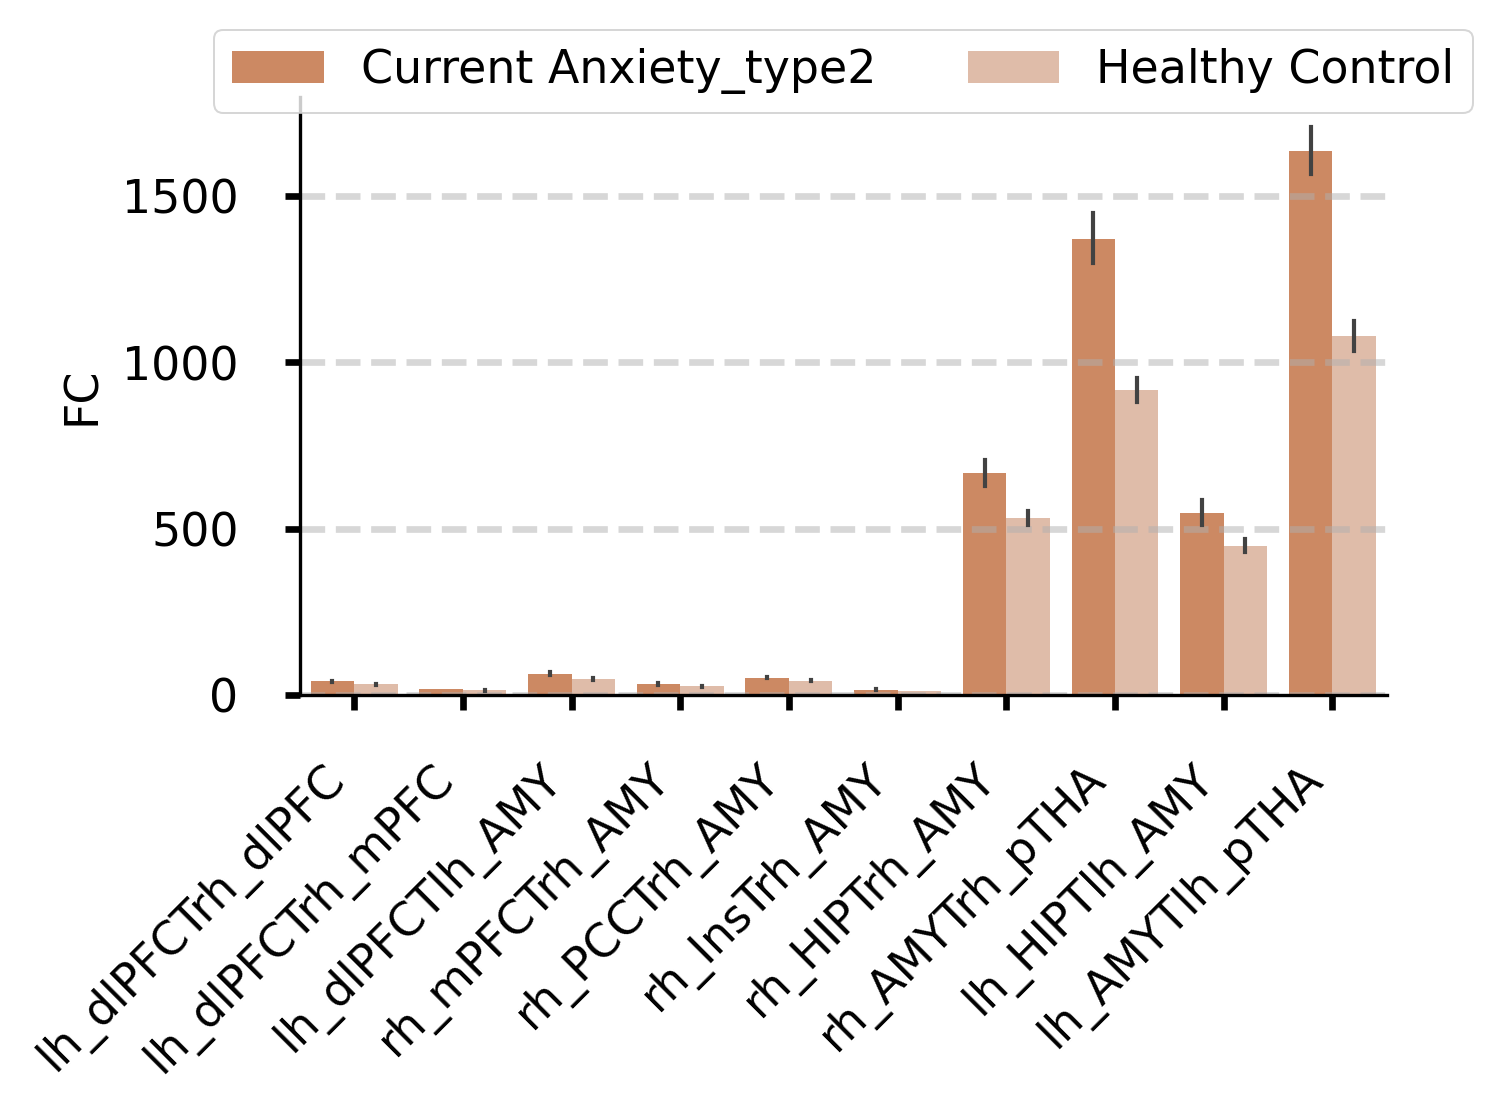

In [146]:
df_bs_type2 = pd.DataFrame(X_type2[:, selected_features_data_set2])
df_bs_type2.columns = list(df_selected_features_type2['ROI'])
df_bs_type2['Anxiety'] = y_type2
# Relabel the 'Anxiety' column
df_bs_type2['Anxiety'] = df_bs_type2['Anxiety'].map({False: 'Healthy Control', True: 'Current Anxiety_type2'})

# Melt the dataframe to long format for seaborn compatibility
df_long = df_bs_type2.melt(id_vars=['Anxiety'], value_vars=df_bs_type2.columns[:-1],
                           var_name='Region', value_name='FC')

# Create a bar plot
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
   "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
# # Create figure and axis
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
default_orange = sns.color_palette("deep")[1]  # Orange (#ff7f0e)
lighter_orange = sns.light_palette(default_orange, n_colors=3)[1]  # Light orange
# Create bar plot with thinner error bars
sns.barplot(
    x="Region", 
    y="FC", 
    hue="Anxiety", 
    data=df_long, 
    err_kws={"linewidth": 1},  # Thinner error bars
    palette=[default_orange, lighter_orange],  # Consistent blue/light blue color scheme
    ax=ax
)
# Fix x-tick positions and labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
# Customize plot
legend = plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Keep only y-grid for clarity
plt.xlabel("")
sns.despine()
plt.ylim(0, 1800)

plt.tight_layout()

# Save and display the plot
#plt.savefig("bar_model2.png")
plt.show()


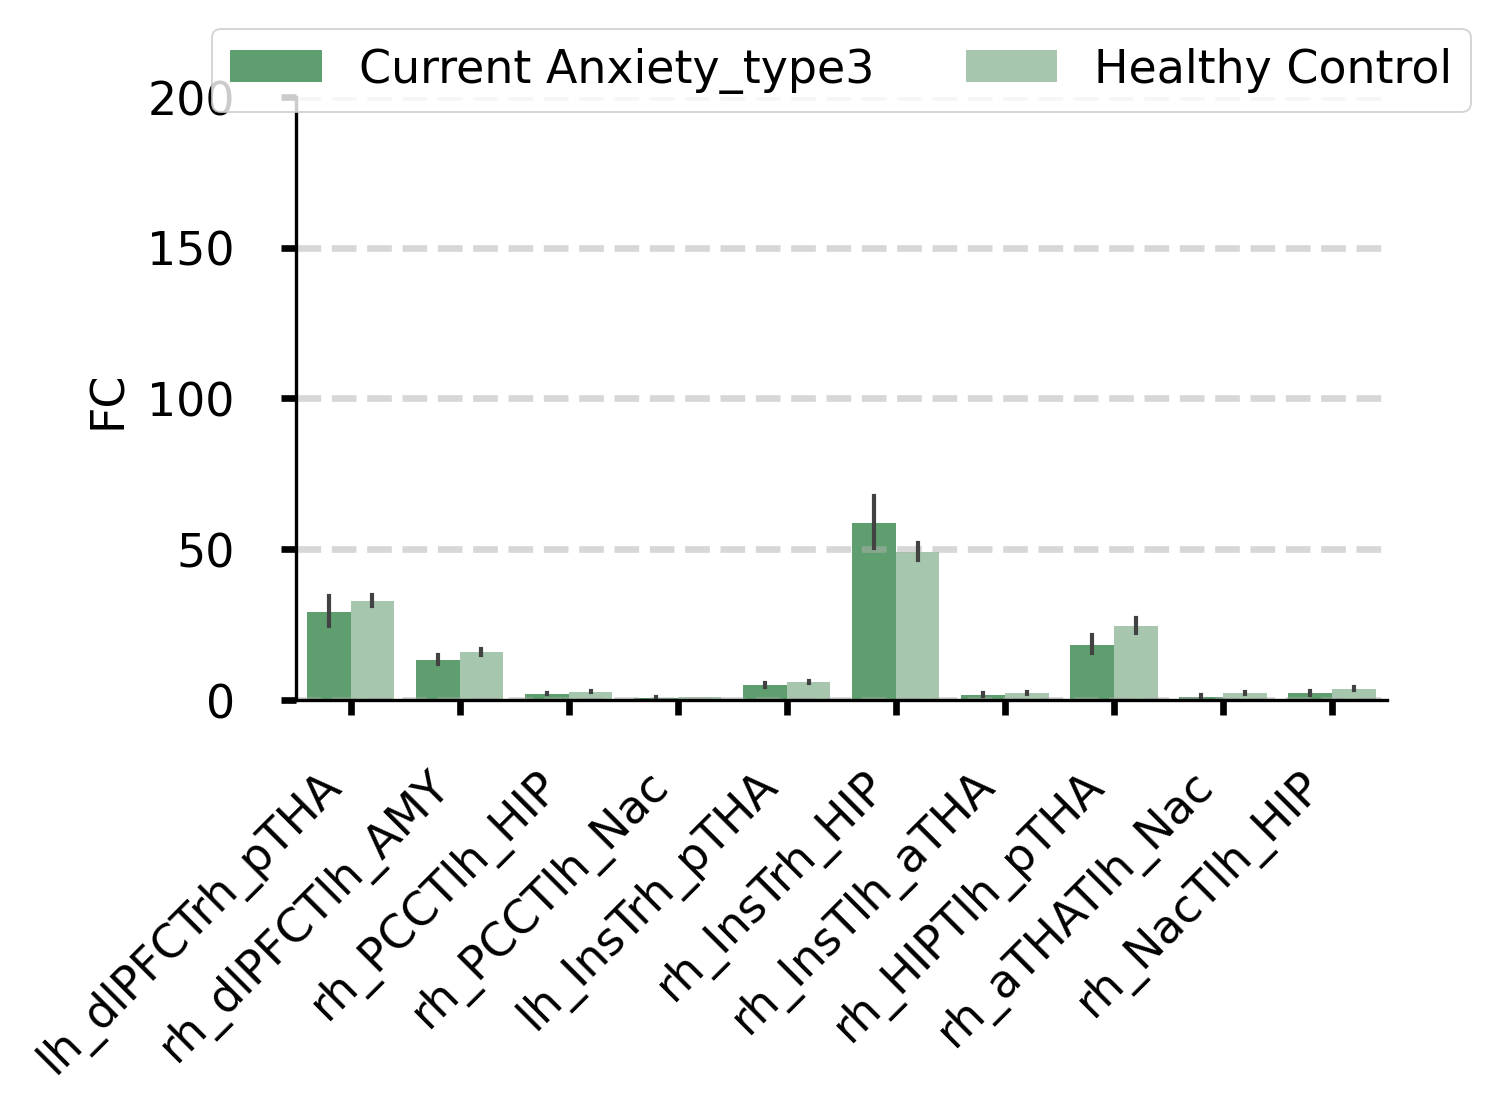

In [148]:
df_bs_type3 = pd.DataFrame(X_type3[:, selected_features_data_set3])
df_bs_type3.columns = list(df_selected_features_type3['ROI'])
df_bs_type3['Anxiety'] = y_type3
# Relabel the 'Anxiety' column
df_bs_type3['Anxiety'] = df_bs_type3['Anxiety'].map({False: 'Healthy Control', True: 'Current Anxiety_type3'})

# Melt the dataframe to long format for seaborn compatibility
df_long = df_bs_type3.melt(id_vars=['Anxiety'], value_vars=df_bs_type3.columns[:-1],
                           var_name='Region', value_name='FC')

# Create a bar plot
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
default_green = sns.color_palette("deep")[2]  # Green (#2ca02c)
lighter_green = sns.light_palette(default_green, n_colors=3)[1]  # Light green
# Create bar plot with thinner error bars
sns.barplot(
    x="Region", 
    y="FC", 
    hue="Anxiety", 
    data=df_long, 
    err_kws={"linewidth": 1},  # Thinner error bars
    palette=[default_green, lighter_green],  # Consistent blue/light blue color scheme
    ax=ax
)
# Fix x-tick positions and labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
# Customize plot
legend = plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Keep only y-grid for clarity
plt.xlabel("")
sns.despine()
plt.ylim(0, 200)

plt.tight_layout()

# Save and display the plot
#plt.savefig("bar_model3.png")
plt.show()


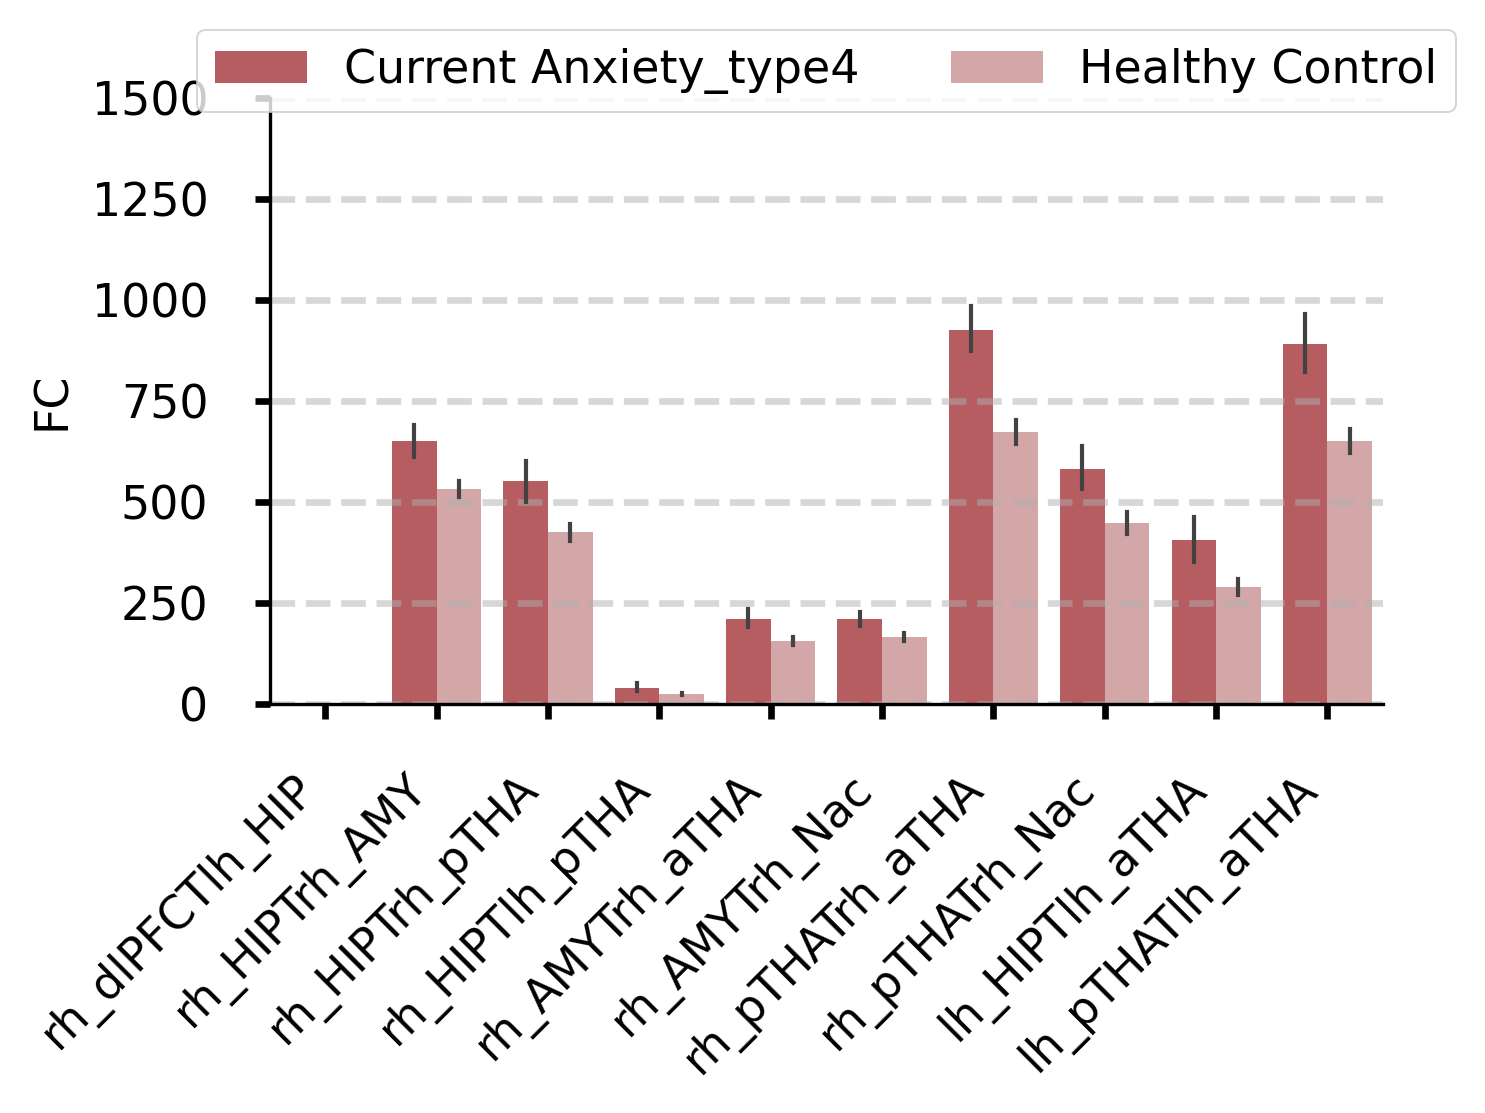

In [150]:
df_bs_type4 = pd.DataFrame(X_type4[:, selected_features_data_set4])
df_bs_type4.columns = list(df_selected_features_type4['ROI'])
df_bs_type4['Anxiety'] = y_type4
# Relabel the 'Anxiety' column
df_bs_type4['Anxiety'] = df_bs_type4['Anxiety'].map({False: 'Healthy Control', True: 'Current Anxiety_type4'})

# Melt the dataframe to long format for seaborn compatibility
df_long = df_bs_type4.melt(id_vars=['Anxiety'], value_vars=df_bs_type4.columns[:-1],
                           var_name='Region', value_name='FC')

fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
default_red = sns.color_palette("deep")[3]  # Red (#d62728)
lighter_red = sns.light_palette(default_red, n_colors=3)[1] 
# Create bar plot with thinner error bars
sns.barplot(
    x="Region", 
    y="FC", 
    hue="Anxiety", 
    data=df_long, 
    err_kws={"linewidth": 1},  # Thinner error bars
    palette=[default_red, lighter_red],  # Consistent blue/light blue color scheme
    ax=ax
)
# Fix x-tick positions and labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
# Customize plot
legend = plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Keep only y-grid for clarity
plt.xlabel("")
sns.despine()
plt.ylim(0, 1500)

plt.tight_layout()

# Save and display the plot
#plt.savefig("bar_model4.png")
plt.show()


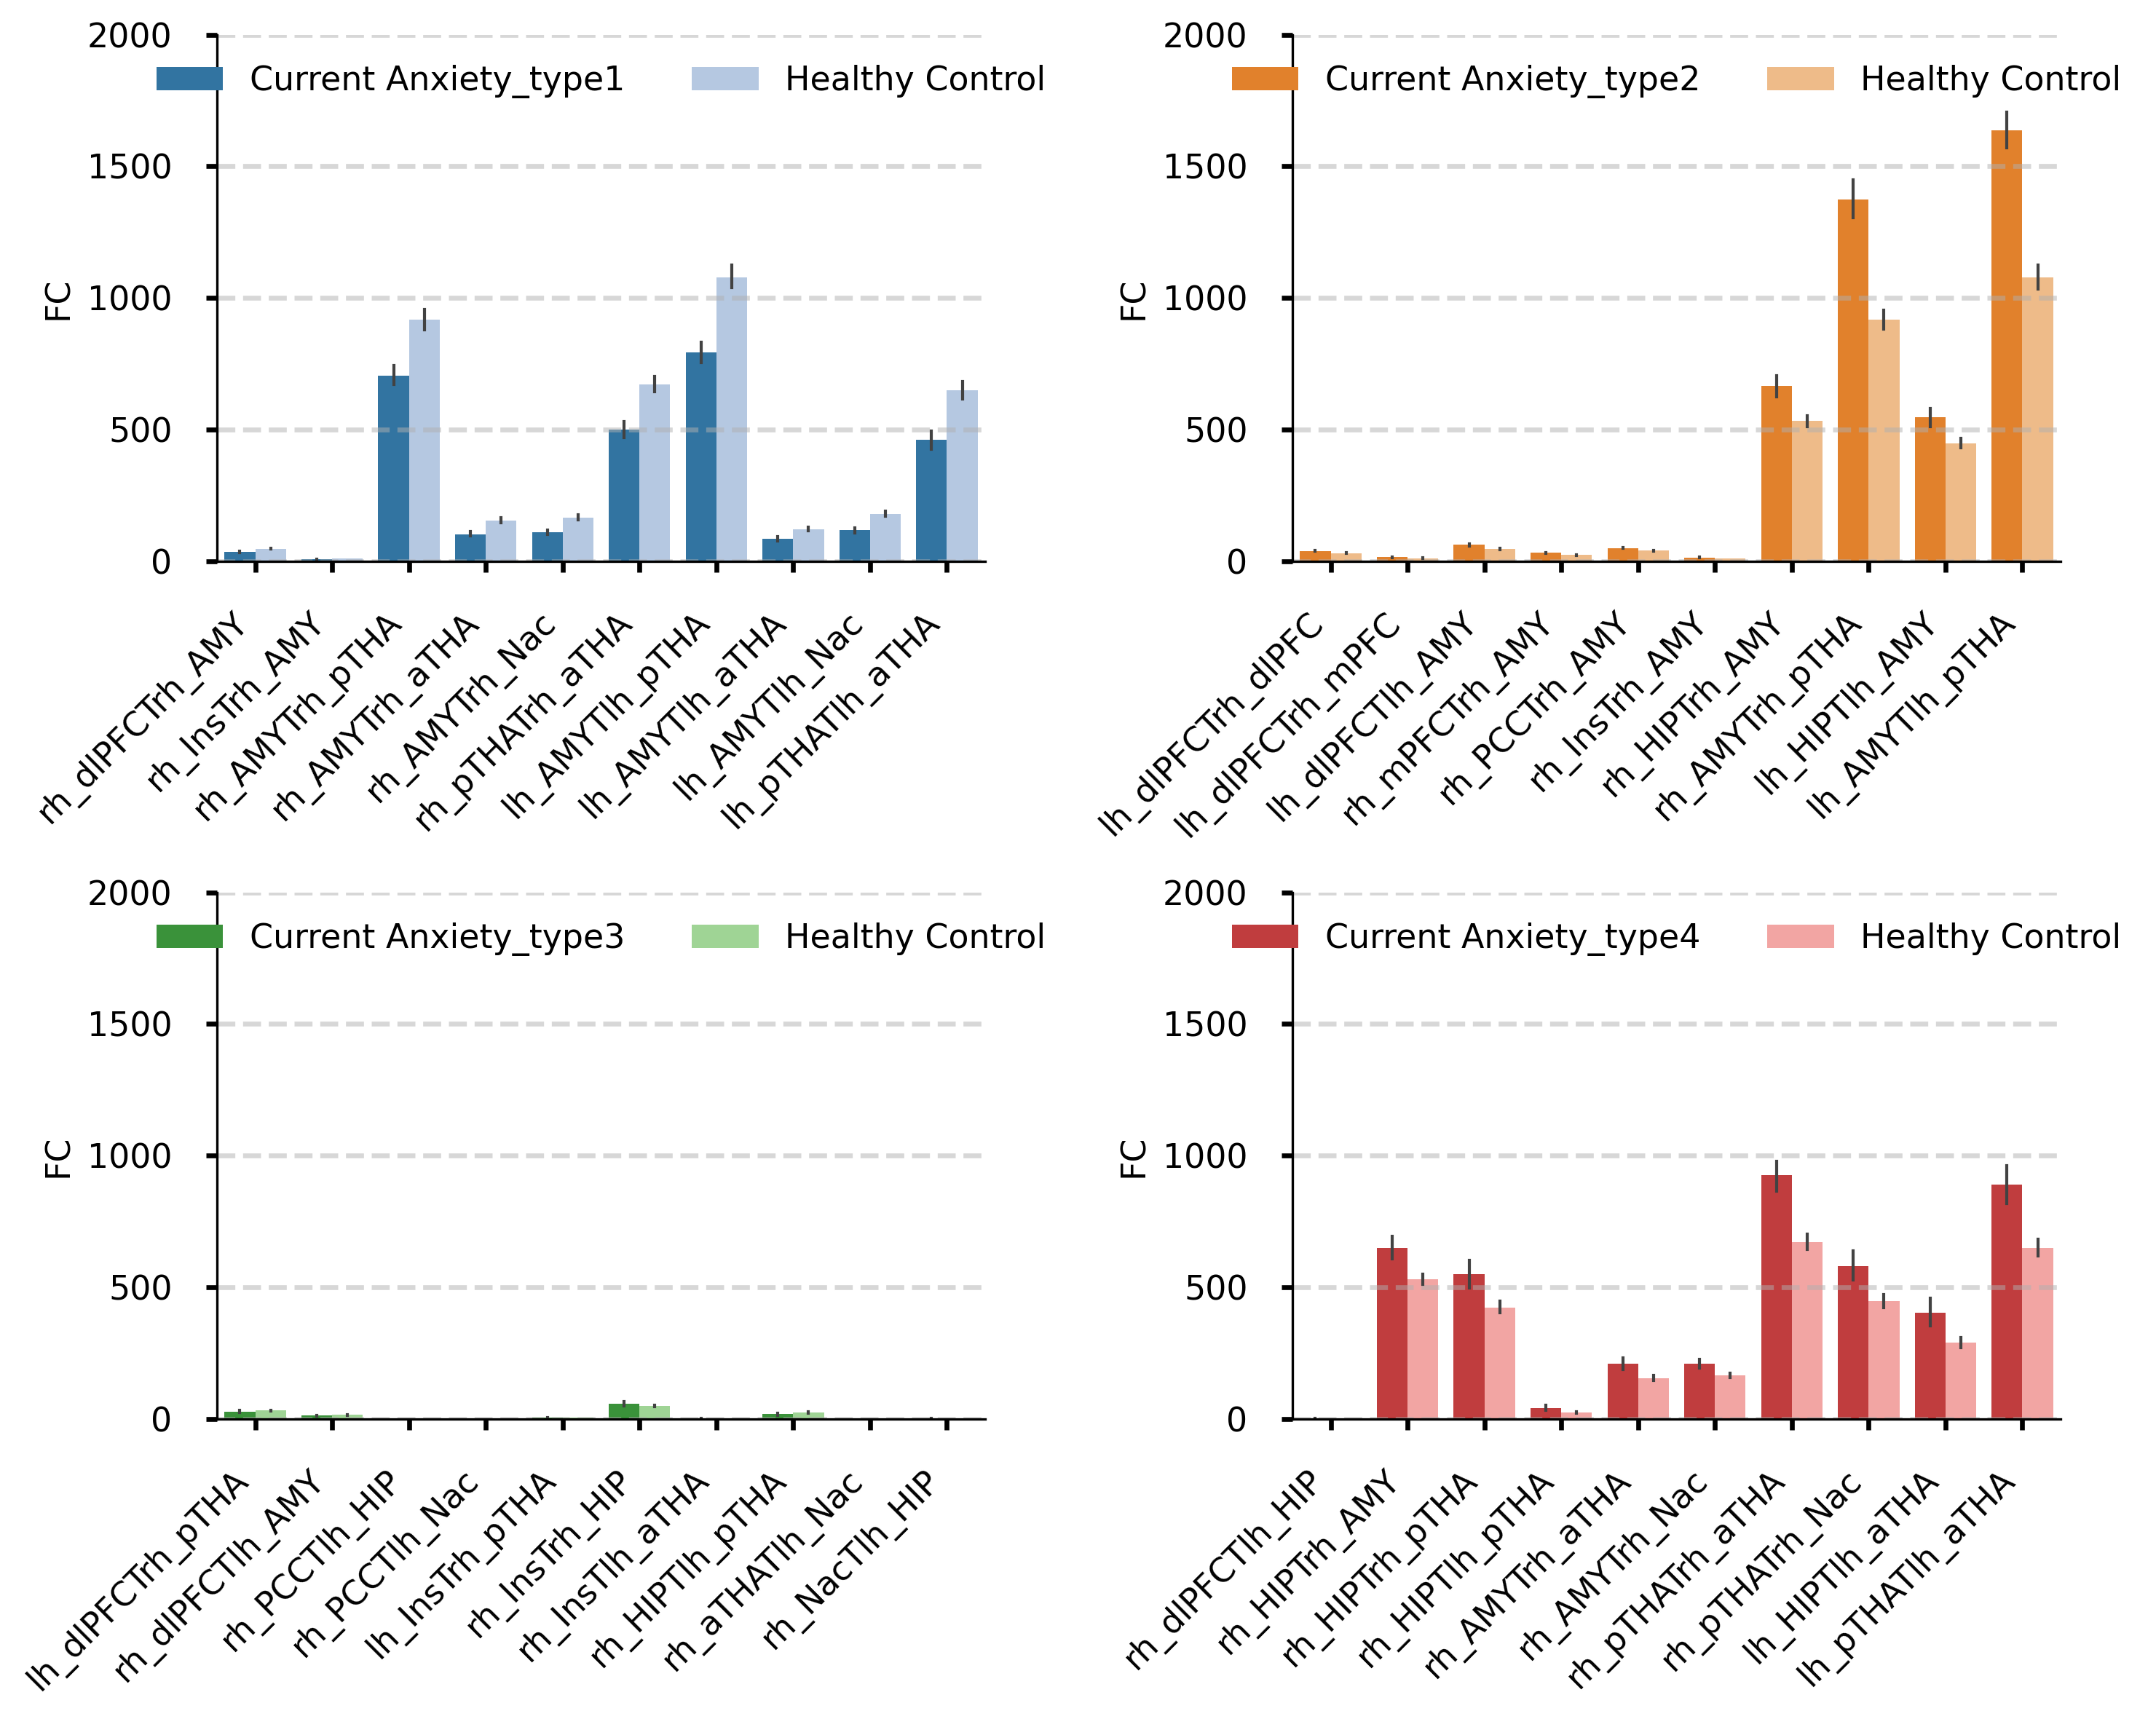

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style and font sizes
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,
    "axes.labelsize": fontsize,
    "axes.titlesize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.fontsize": fontsize,
})

# Define figure and axes (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)

# Define dataset mappings
datasets = [
    (X_type1, selected_features_data_set1, df_selected_features_type1, y_type1, 'Current Anxiety_type1', axes[0, 0], ["#1f77b4", "#aec7e8"]),  # Blue shades
    (X_type2, selected_features_data_set2, df_selected_features_type2, y_type2, 'Current Anxiety_type2', axes[0, 1], ["#ff7f0e", "#ffbb78"]),  # Orange shades
    (X_type3, selected_features_data_set3, df_selected_features_type3, y_type3, 'Current Anxiety_type3', axes[1, 0], ["#2ca02c", "#98df8a"]),  # Green shades
    (X_type4, selected_features_data_set4, df_selected_features_type4, y_type4, 'Current Anxiety_type4', axes[1, 1], ["#d62728", "#ff9896"]),  # Red shades
]

# Iterate through datasets and generate subplots
for X_type, selected_features, df_selected_features, y_type, anxiety_label, ax, palette in datasets:
    df_bs = pd.DataFrame(X_type[:, selected_features])
    df_bs.columns = list(df_selected_features['ROI'])
    df_bs['Anxiety'] = y_type.map({False: 'Healthy Control', True: anxiety_label})

    # Melt for seaborn
    df_long = df_bs.melt(id_vars=['Anxiety'], var_name='Region', value_name='FC')

    # Bar plot
    sns.barplot(
        x="Region", y="FC", hue="Anxiety", data=df_long, err_kws={"linewidth": 1},
        palette=palette, ax=ax
    )

    # Customize plot
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("")
    ax.set_ylim(0, 2000)

    # Fix x-tick labels issue
    ax.set_xticks(range(len(ax.get_xticklabels())))  # Ensure fixed tick positions
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Modify legend: single-row, centered below each plot, adjusted height
    ax.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1), ncol=2, frameon=False)

sns.despine()

# Adjust layout
plt.tight_layout()
plt.savefig("bar_all_models.png")
plt.show()
